In [1]:
%matplotlib inline

# Radial velocity fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1


In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

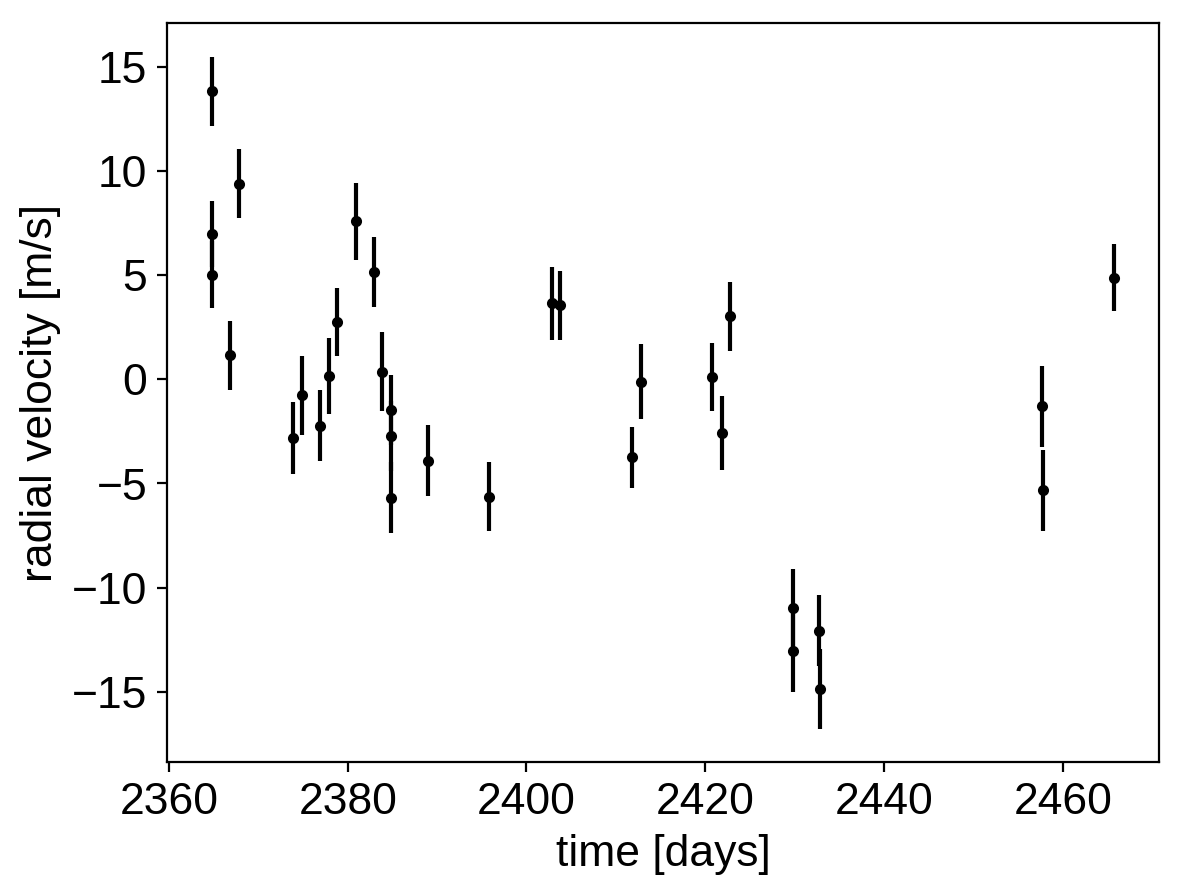

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)("P", mu=np.array(periods), sd=np.array(period_errs),
                                     shape=2, testval=np.array(periods))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)("logK", mu=np.log(Ks), sd=10.0,
                                        shape=2, testval=np.log(Ks))

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=2, testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

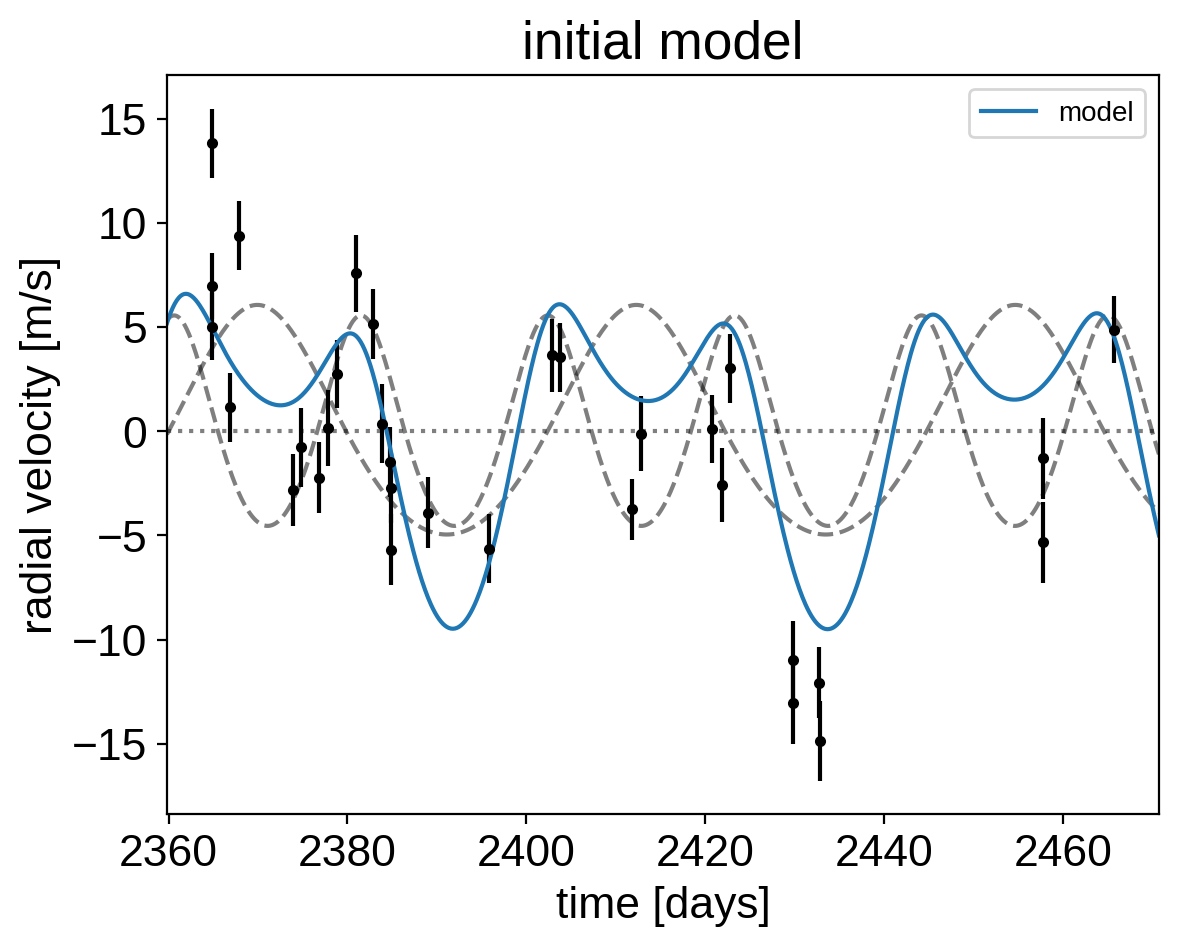

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-7.973266e+01]

1it [00:00, 302.66it/s, logp=-7.973266e+01]

2it [00:00, 413.84it/s, logp=-7.973266e+01]

3it [00:00, 437.91it/s, logp=-5.305392e+06]

4it [00:00, 472.27it/s, logp=-7.966783e+01]

5it [00:00, 474.16it/s, logp=-7.953812e+01]

6it [00:00, 498.23it/s, logp=-7.904438e+01]

7it [00:00, 520.19it/s, logp=-7.747076e+01]

8it [00:00, 537.71it/s, logp=-7.344108e+01]

9it [00:00, 549.11it/s, logp=-6.722892e+01]

10it [00:00, 552.90it/s, logp=-6.484820e+01]

11it [00:00, 552.44it/s, logp=-6.484820e+01]

12it [00:00, 556.71it/s, logp=-6.484820e+01]

13it [00:04,  3.09it/s, logp=-6.484820e+01] 


message: Optimization terminated successfully.
logp: -79.73266285618838 -> -64.8482026233154


optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.484820e+01]

1it [00:00, 250.45it/s, logp=-6.484820e+01]

2it [00:00, 351.84it/s, logp=-6.484820e+01]

3it [00:00, 374.71it/s, logp=-4.990134e+09]

4it [00:00, 370.37it/s, logp=-6.484832e+01]

5it [00:00, 379.64it/s, logp=-6.484777e+01]

6it [00:00, 369.83it/s, logp=-6.519268e+01]

7it [00:00, 379.51it/s, logp=-6.484777e+01]

8it [00:00, 356.55it/s, logp=-6.484777e+01]

9it [00:00, 363.90it/s, logp=-6.484776e+01]

10it [00:00, 372.56it/s, logp=-6.484774e+01]

11it [00:00, 370.39it/s, logp=-6.484767e+01]

12it [00:00, 370.61it/s, logp=-6.484739e+01]

13it [00:00, 377.32it/s, logp=-6.484633e+01]

14it [00:00, 372.44it/s, logp=-6.484353e+01]

15it [00:00, 369.76it/s, logp=-6.483426e+01]

16it [00:00, 354.84it/s, logp=-6.481055e+01]

17it [00:00, 359.49it/s, logp=-6.472940e+01]

18it [00:00, 358.44it/s, logp=-6.451928e+01]

19it [00:00, 360.62it/s, logp=-6.371170e+01]

20it [00:00, 364.52it/s, logp=-6.096678e+01]

21it [00:00, 364.31it/s, logp=-5.708652e+01]

22it [00:00, 372.06it/s, logp=-5.027536e+01]

23it [00:00, 380.65it/s, logp=-2.386568e+02]

24it [00:00, 389.99it/s, logp=-4.912172e+01]

25it [00:00, 397.86it/s, logp=-4.707357e+01]

26it [00:00, 406.00it/s, logp=-4.319328e+01]

27it [00:00, 413.49it/s, logp=-3.608487e+01]

28it [00:00, 420.29it/s, logp=-2.498567e+01]

29it [00:00, 427.23it/s, logp=-2.442071e+01]

30it [00:00, 433.45it/s, logp=-2.333036e+01]

31it [00:00, 440.15it/s, logp=-2.011091e+01]

32it [00:00, 444.44it/s, logp=-1.751350e+01]

33it [00:00, 441.44it/s, logp=-1.714559e+01]

34it [00:00, 442.67it/s, logp=-1.693796e+01]

35it [00:00, 444.62it/s, logp=-1.684943e+01]

36it [00:00, 446.91it/s, logp=-1.676095e+01]

37it [00:00, 446.37it/s, logp=-1.673569e+01]

38it [00:00, 446.34it/s, logp=-1.672214e+01]

39it [00:00, 446.36it/s, logp=-1.670758e+01]

40it [00:00, 446.37it/s, logp=-1.668064e+01]

41it [00:00, 444.50it/s, logp=-1.662858e+01]

42it [00:00, 444.47it/s, logp=-1.658058e+01]

43it [00:00, 444.16it/s, logp=-1.655728e+01]

44it [00:00, 442.77it/s, logp=-1.662929e+01]

45it [00:00, 449.46it/s, logp=-1.662929e+01]

45it [00:00, 449.46it/s, logp=-1.647872e+01]

46it [00:00, 449.46it/s, logp=-1.635178e+01]

47it [00:00, 449.46it/s, logp=-1.613280e+01]

48it [00:00, 449.46it/s, logp=-1.577352e+01]

49it [00:00, 449.46it/s, logp=-1.525205e+01]

50it [00:00, 449.46it/s, logp=-1.849895e+01]

51it [00:00, 449.46it/s, logp=-1.514689e+01]

52it [00:00, 449.46it/s, logp=-1.501721e+01]

53it [00:00, 449.46it/s, logp=-1.496658e+01]

54it [00:00, 449.46it/s, logp=-1.495457e+01]

55it [00:00, 449.46it/s, logp=-1.494704e+01]

56it [00:00, 449.46it/s, logp=-1.494509e+01]

57it [00:00, 449.46it/s, logp=-1.494181e+01]

58it [00:00, 449.46it/s, logp=-1.493619e+01]

59it [00:00, 449.46it/s, logp=-1.492655e+01]

60it [00:00, 449.46it/s, logp=-1.491151e+01]

61it [00:00, 449.46it/s, logp=-1.489345e+01]

62it [00:00, 449.46it/s, logp=-1.486580e+01]

63it [00:00, 449.46it/s, logp=-1.483881e+01]

64it [00:00, 449.46it/s, logp=-1.479783e+01]

65it [00:00, 449.46it/s, logp=-1.475797e+01]

66it [00:00, 449.46it/s, logp=-1.470224e+01]

67it [00:00, 449.46it/s, logp=-1.466581e+01]

68it [00:00, 449.46it/s, logp=-1.465792e+01]

69it [00:00, 449.46it/s, logp=-1.460984e+01]

70it [00:00, 449.46it/s, logp=-1.453216e+01]

71it [00:00, 449.46it/s, logp=-1.441150e+01]

72it [00:00, 449.46it/s, logp=-1.431230e+01]

73it [00:00, 449.46it/s, logp=-1.436794e+01]

74it [00:00, 449.46it/s, logp=-1.429690e+01]

75it [00:00, 449.46it/s, logp=-1.428194e+01]

76it [00:00, 449.46it/s, logp=-1.427769e+01]

77it [00:00, 449.46it/s, logp=-1.427703e+01]

78it [00:00, 449.46it/s, logp=-1.427688e+01]

79it [00:00, 449.46it/s, logp=-1.427678e+01]

80it [00:00, 449.46it/s, logp=-1.427677e+01]

81it [00:00, 449.46it/s, logp=-1.427676e+01]

82it [00:00, 449.46it/s, logp=-1.427676e+01]

83it [00:00, 449.46it/s, logp=-1.427676e+01]

84it [00:00, 449.46it/s, logp=-1.427676e+01]

85it [00:00, 449.46it/s, logp=-1.427676e+01]

86it [00:00, 434.12it/s, logp=-1.427676e+01]

86it [00:00, 434.12it/s, logp=-1.427676e+01]

87it [00:00, 434.12it/s, logp=-1.427676e+01]

88it [00:00, 434.12it/s, logp=-1.427676e+01]

89it [00:00, 434.12it/s, logp=-1.427676e+01]

90it [00:00, 434.12it/s, logp=-1.427676e+01]

91it [00:00, 434.12it/s, logp=-1.427676e+01]

92it [00:00, 434.12it/s, logp=-1.427676e+01]

93it [00:00, 434.12it/s, logp=-1.427676e+01]

94it [00:00, 434.12it/s, logp=-1.427676e+01]

95it [00:00, 434.12it/s, logp=-1.427676e+01]

96it [00:00, 434.12it/s, logp=-1.427676e+01]

97it [00:00, 434.12it/s, logp=-1.427676e+01]

98it [00:00, 434.12it/s, logp=-1.427676e+01]

99it [00:00, 434.12it/s, logp=-1.427676e+01]

100it [00:00, 434.12it/s, logp=-1.427676e+01]

101it [00:00, 434.12it/s, logp=-1.427676e+01]

102it [00:00, 434.12it/s, logp=-1.427676e+01]

103it [00:00, 434.12it/s, logp=-1.427676e+01]

104it [00:00, 434.12it/s, logp=-1.427676e+01]

105it [00:00, 434.12it/s, logp=-1.427676e+01]

106it [00:00, 434.12it/s, logp=-1.427676e+01]

107it [00:00, 434.12it/s, logp=-1.427676e+01]

108it [00:00, 434.12it/s, logp=-1.427676e+01]

109it [00:00, 434.12it/s, logp=-1.427676e+01]

110it [00:00, 434.12it/s, logp=-1.427676e+01]

111it [00:00, 434.12it/s, logp=-1.427676e+01]

112it [00:00, 434.12it/s, logp=-1.427676e+01]

113it [00:00, 434.12it/s, logp=-1.427676e+01]

114it [00:00, 434.12it/s, logp=-1.427676e+01]

115it [00:00, 434.12it/s, logp=-1.427676e+01]

116it [00:00, 434.12it/s, logp=-1.427676e+01]

117it [00:00, 434.12it/s, logp=-1.427676e+01]

118it [00:00, 434.12it/s, logp=-1.427676e+01]

119it [00:00, 434.12it/s, logp=-1.427676e+01]

120it [00:00, 434.12it/s, logp=-1.427676e+01]

121it [00:00, 434.12it/s, logp=-1.427676e+01]

122it [00:00, 434.12it/s, logp=-1.427676e+01]

123it [00:00, 434.12it/s, logp=-1.427676e+01]

124it [00:00, 434.12it/s, logp=-1.427676e+01]

125it [00:00, 434.12it/s, logp=-1.427676e+01]

126it [00:00, 434.12it/s, logp=-1.427676e+01]

127it [00:00, 425.53it/s, logp=-1.427676e+01]

127it [00:00, 425.53it/s, logp=-1.427676e+01]

128it [00:00, 425.53it/s, logp=-1.427676e+01]

129it [00:00, 425.53it/s, logp=-1.427676e+01]

130it [00:00, 425.53it/s, logp=-1.427676e+01]

131it [00:00, 425.53it/s, logp=-1.427676e+01]

132it [00:00, 425.53it/s, logp=-1.427676e+01]

133it [00:00, 425.53it/s, logp=-1.427676e+01]

134it [00:00, 425.53it/s, logp=-1.427676e+01]

135it [00:00, 425.53it/s, logp=-1.427676e+01]

136it [00:00, 425.53it/s, logp=-1.427676e+01]

137it [00:00, 425.53it/s, logp=-1.427676e+01]

138it [00:00, 425.53it/s, logp=-1.427676e+01]

139it [00:00, 425.53it/s, logp=-1.427676e+01]

140it [00:00, 425.53it/s, logp=-1.427676e+01]

141it [00:00, 425.53it/s, logp=-1.427676e+01]

142it [00:00, 425.53it/s, logp=-1.427676e+01]

143it [00:00, 425.53it/s, logp=-1.427676e+01]

144it [00:00, 425.53it/s, logp=-1.427676e+01]

145it [00:00, 425.53it/s, logp=-1.427676e+01]

146it [00:00, 425.53it/s, logp=-1.427676e+01]

147it [00:00, 425.53it/s, logp=-1.427676e+01]

148it [00:00, 425.53it/s, logp=-1.427676e+01]

149it [00:00, 425.53it/s, logp=-1.427676e+01]

150it [00:00, 425.53it/s, logp=-1.427676e+01]

151it [00:00, 425.53it/s, logp=-1.427676e+01]

152it [00:00, 425.53it/s, logp=-1.427676e+01]

153it [00:00, 425.53it/s, logp=-1.427676e+01]

154it [00:00, 425.53it/s, logp=-1.427676e+01]

155it [00:00, 425.53it/s, logp=-1.427676e+01]

156it [00:00, 425.53it/s, logp=-1.427676e+01]

157it [00:00, 425.53it/s, logp=-1.427676e+01]

158it [00:00, 425.53it/s, logp=-1.427676e+01]

159it [00:00, 425.53it/s, logp=-1.427676e+01]

160it [00:00, 425.53it/s, logp=-1.427676e+01]

161it [00:00, 425.53it/s, logp=-1.427676e+01]

162it [00:00, 425.53it/s, logp=-1.427676e+01]

163it [00:00, 425.53it/s, logp=-1.427676e+01]

164it [00:00, 425.53it/s, logp=-1.427676e+01]

165it [00:00, 425.53it/s, logp=-1.427676e+01]

166it [00:00, 425.53it/s, logp=-1.427676e+01]

167it [00:00, 425.53it/s, logp=-1.427676e+01]

168it [00:00, 425.53it/s, logp=-1.427676e+01]

169it [00:00, 425.53it/s, logp=-1.427676e+01]

170it [00:00, 425.53it/s, logp=-1.427676e+01]

171it [00:00, 429.25it/s, logp=-1.427676e+01]

171it [00:00, 429.25it/s, logp=-1.427676e+01]

172it [00:00, 429.25it/s, logp=-1.427676e+01]

173it [00:00, 429.25it/s, logp=-1.427676e+01]

174it [00:00, 429.25it/s, logp=-1.427676e+01]

175it [00:00, 429.25it/s, logp=-1.427676e+01]

176it [00:00, 429.25it/s, logp=-1.427676e+01]

177it [00:00, 429.25it/s, logp=-1.427676e+01]

178it [00:00, 429.25it/s, logp=-1.427676e+01]

179it [00:00, 429.25it/s, logp=-1.427676e+01]

180it [00:00, 429.25it/s, logp=-1.427676e+01]

181it [00:00, 429.25it/s, logp=-1.427676e+01]

182it [00:00, 429.25it/s, logp=-1.427676e+01]

183it [00:00, 429.25it/s, logp=-1.427676e+01]

184it [00:00, 429.25it/s, logp=-1.427676e+01]

185it [00:00, 429.25it/s, logp=-1.427676e+01]

186it [00:00, 429.25it/s, logp=-1.427676e+01]

187it [00:00, 429.25it/s, logp=-1.427676e+01]

188it [00:00, 429.25it/s, logp=-1.427676e+01]

189it [00:00, 429.25it/s, logp=-1.427676e+01]

190it [00:00, 429.25it/s, logp=-1.427676e+01]

191it [00:00, 429.25it/s, logp=-1.427676e+01]

192it [00:00, 429.25it/s, logp=-1.427676e+01]

193it [00:00, 429.25it/s, logp=-1.427676e+01]

194it [00:00, 429.25it/s, logp=-1.427676e+01]

195it [00:00, 429.25it/s, logp=-1.427676e+01]

196it [00:00, 429.25it/s, logp=-1.427676e+01]

197it [00:00, 429.25it/s, logp=-1.427676e+01]

198it [00:00, 429.25it/s, logp=-1.427676e+01]

199it [00:00, 429.25it/s, logp=-1.427676e+01]

200it [00:00, 429.25it/s, logp=-1.427676e+01]

201it [00:00, 429.25it/s, logp=-1.427676e+01]

202it [00:00, 429.25it/s, logp=-1.427676e+01]

203it [00:00, 429.25it/s, logp=-1.427676e+01]

204it [00:00, 429.25it/s, logp=-1.427676e+01]

205it [00:00, 429.25it/s, logp=-1.427676e+01]

206it [00:00, 401.45it/s, logp=-1.427676e+01]

206it [00:00, 401.45it/s, logp=-1.427676e+01]

207it [00:00, 401.45it/s, logp=-1.427676e+01]

208it [00:00, 401.45it/s, logp=-1.427676e+01]

209it [00:00, 401.45it/s, logp=-1.427676e+01]

210it [00:00, 401.45it/s, logp=-1.427676e+01]

211it [00:00, 401.45it/s, logp=-1.427676e+01]

212it [00:00, 401.45it/s, logp=-1.427676e+01]

213it [00:00, 247.47it/s, logp=-1.427676e+01]


message: Desired error not necessarily achieved due to precision loss.
logp: -64.8482026233154 -> -14.27676026238089


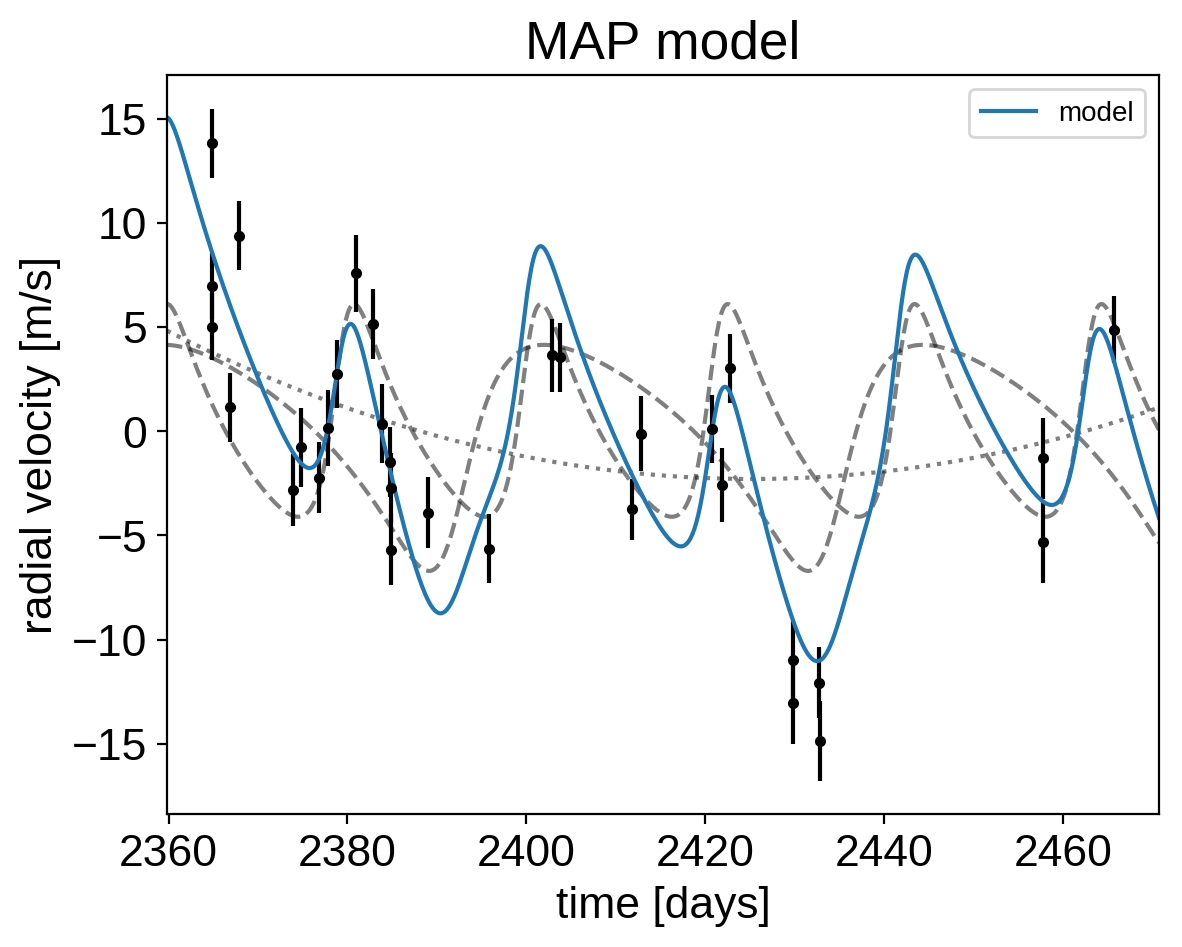

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :func:`exoplanet.get_dense_nuts_step` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=4000, draws=4000, step=xo.get_dense_nuts_step(target_accept=0.95))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 19/32000 [00:00<02:50, 187.47draws/s]

Sampling 4 chains:   0%|          | 27/32000 [00:00<04:27, 119.63draws/s]

Sampling 4 chains:   0%|          | 35/32000 [00:00<05:25, 98.21draws/s] 

Sampling 4 chains:   0%|          | 43/32000 [00:00<06:03, 87.87draws/s]

Sampling 4 chains:   0%|          | 50/32000 [00:00<06:34, 81.05draws/s]

Sampling 4 chains:   0%|          | 57/32000 [00:00<07:14, 73.45draws/s]

Sampling 4 chains:   0%|          | 64/32000 [00:00<07:31, 70.72draws/s]

Sampling 4 chains:   0%|          | 72/32000 [00:00<07:38, 69.70draws/s]

Sampling 4 chains:   0%|          | 80/32000 [00:01<07:43, 68.82draws/s]

Sampling 4 chains:   0%|          | 88/32000 [00:01<07:46, 68.45draws/s]

Sampling 4 chains:   0%|          | 96/32000 [00:01<07:49, 67.91draws/s]

Sampling 4 chains:   0%|          | 104/32000 [00:01<07:56, 66.95draws/s]

Sampling 4 chains:   0%|          | 112/32000 [00:01<07:58, 66.66draws/s]

Sampling 4 chains:   0%|          | 120/32000 [00:01<08:00, 66.40draws/s]

Sampling 4 chains:   0%|          | 128/32000 [00:01<07:55, 66.97draws/s]

Sampling 4 chains:   0%|          | 136/32000 [00:01<07:54, 67.09draws/s]

Sampling 4 chains:   0%|          | 143/32000 [00:01<08:10, 65.01draws/s]

Sampling 4 chains:   0%|          | 150/32000 [00:02<08:26, 62.89draws/s]

Sampling 4 chains:   0%|          | 157/32000 [00:02<08:32, 62.14draws/s]

Sampling 4 chains:   1%|          | 165/32000 [00:02<08:21, 63.53draws/s]

Sampling 4 chains:   1%|          | 173/32000 [00:02<08:09, 64.96draws/s]

Sampling 4 chains:   1%|          | 180/32000 [00:02<07:59, 66.39draws/s]

Sampling 4 chains:   1%|          | 187/32000 [00:02<08:06, 65.42draws/s]

Sampling 4 chains:   1%|          | 194/32000 [00:02<08:00, 66.23draws/s]

Sampling 4 chains:   1%|          | 202/32000 [00:02<07:54, 66.95draws/s]

Sampling 4 chains:   1%|          | 210/32000 [00:02<07:51, 67.38draws/s]

Sampling 4 chains:   1%|          | 217/32000 [00:03<07:48, 67.80draws/s]

Sampling 4 chains:   1%|          | 224/32000 [00:03<08:02, 65.82draws/s]

Sampling 4 chains:   1%|          | 231/32000 [00:03<08:14, 64.25draws/s]

Sampling 4 chains:   1%|          | 239/32000 [00:03<08:05, 65.39draws/s]

Sampling 4 chains:   1%|          | 247/32000 [00:03<07:55, 66.75draws/s]

Sampling 4 chains:   1%|          | 255/32000 [00:03<07:51, 67.34draws/s]

Sampling 4 chains:   1%|          | 263/32000 [00:03<07:47, 67.95draws/s]

Sampling 4 chains:   1%|          | 271/32000 [00:03<07:44, 68.32draws/s]

Sampling 4 chains:   1%|          | 278/32000 [00:04<07:44, 68.36draws/s]

Sampling 4 chains:   1%|          | 286/32000 [00:04<07:50, 67.41draws/s]

Sampling 4 chains:   1%|          | 294/32000 [00:04<07:53, 66.98draws/s]

Sampling 4 chains:   1%|          | 302/32000 [00:04<07:50, 67.34draws/s]

Sampling 4 chains:   1%|          | 310/32000 [00:04<07:44, 68.26draws/s]

Sampling 4 chains:   1%|          | 317/32000 [00:04<07:41, 68.71draws/s]

Sampling 4 chains:   1%|          | 325/32000 [00:04<07:43, 68.28draws/s]

Sampling 4 chains:   1%|          | 333/32000 [00:04<07:42, 68.47draws/s]

Sampling 4 chains:   1%|          | 340/32000 [00:04<07:43, 68.30draws/s]

Sampling 4 chains:   1%|          | 348/32000 [00:05<07:45, 67.96draws/s]

Sampling 4 chains:   1%|          | 356/32000 [00:05<07:47, 67.74draws/s]

Sampling 4 chains:   1%|          | 364/32000 [00:05<07:48, 67.50draws/s]

Sampling 4 chains:   1%|          | 372/32000 [00:05<07:52, 66.91draws/s]

Sampling 4 chains:   1%|          | 380/32000 [00:05<07:52, 66.90draws/s]

Sampling 4 chains:   1%|          | 388/32000 [00:05<07:45, 67.85draws/s]

Sampling 4 chains:   1%|          | 396/32000 [00:05<07:41, 68.52draws/s]

Sampling 4 chains:   1%|▏         | 404/32000 [00:05<07:39, 68.80draws/s]

Sampling 4 chains:   1%|▏         | 412/32000 [00:05<07:37, 69.02draws/s]

Sampling 4 chains:   1%|▏         | 420/32000 [00:06<07:35, 69.31draws/s]

Sampling 4 chains:   1%|▏         | 428/32000 [00:06<07:34, 69.51draws/s]

Sampling 4 chains:   1%|▏         | 436/32000 [00:06<07:37, 68.94draws/s]

Sampling 4 chains:   1%|▏         | 444/32000 [00:06<07:39, 68.68draws/s]

Sampling 4 chains:   1%|▏         | 452/32000 [00:06<07:42, 68.15draws/s]

Sampling 4 chains:   1%|▏         | 460/32000 [00:06<07:42, 68.16draws/s]

Sampling 4 chains:   1%|▏         | 467/32000 [00:06<07:59, 65.82draws/s]

Sampling 4 chains:   1%|▏         | 475/32000 [00:06<07:53, 66.56draws/s]

Sampling 4 chains:   2%|▏         | 483/32000 [00:07<07:50, 66.99draws/s]

Sampling 4 chains:   2%|▏         | 491/32000 [00:07<07:46, 67.47draws/s]

Sampling 4 chains:   2%|▏         | 499/32000 [00:07<07:44, 67.79draws/s]

Sampling 4 chains:   2%|▏         | 507/32000 [00:07<07:48, 67.26draws/s]

Sampling 4 chains:   2%|▏         | 515/32000 [00:07<07:45, 67.67draws/s]

Sampling 4 chains:   2%|▏         | 523/32000 [00:07<07:45, 67.63draws/s]

Sampling 4 chains:   2%|▏         | 531/32000 [00:07<07:39, 68.52draws/s]

Sampling 4 chains:   2%|▏         | 539/32000 [00:07<07:35, 69.00draws/s]

Sampling 4 chains:   2%|▏         | 547/32000 [00:07<07:35, 68.98draws/s]

Sampling 4 chains:   2%|▏         | 555/32000 [00:08<07:34, 69.23draws/s]

Sampling 4 chains:   2%|▏         | 562/32000 [00:08<07:38, 68.53draws/s]

Sampling 4 chains:   2%|▏         | 569/32000 [00:08<07:53, 66.42draws/s]

Sampling 4 chains:   2%|▏         | 577/32000 [00:08<07:47, 67.16draws/s]

Sampling 4 chains:   2%|▏         | 585/32000 [00:08<07:43, 67.80draws/s]

Sampling 4 chains:   2%|▏         | 593/32000 [00:08<07:40, 68.27draws/s]

Sampling 4 chains:   2%|▏         | 600/32000 [00:08<07:37, 68.69draws/s]

Sampling 4 chains:   2%|▏         | 607/32000 [00:08<07:38, 68.51draws/s]

Sampling 4 chains:   2%|▏         | 614/32000 [00:08<07:35, 68.86draws/s]

Sampling 4 chains:   2%|▏         | 621/32000 [00:09<07:48, 67.01draws/s]

Sampling 4 chains:   2%|▏         | 629/32000 [00:09<07:44, 67.55draws/s]

Sampling 4 chains:   2%|▏         | 637/32000 [00:09<07:40, 68.08draws/s]

Sampling 4 chains:   2%|▏         | 644/32000 [00:09<07:43, 67.69draws/s]

Sampling 4 chains:   2%|▏         | 651/32000 [00:09<07:42, 67.78draws/s]

Sampling 4 chains:   2%|▏         | 659/32000 [00:09<08:02, 64.97draws/s]

Sampling 4 chains:   2%|▏         | 667/32000 [00:09<07:50, 66.55draws/s]

Sampling 4 chains:   2%|▏         | 675/32000 [00:09<07:42, 67.74draws/s]

Sampling 4 chains:   2%|▏         | 683/32000 [00:09<07:36, 68.60draws/s]

Sampling 4 chains:   2%|▏         | 691/32000 [00:10<07:33, 69.10draws/s]

Sampling 4 chains:   2%|▏         | 699/32000 [00:10<07:33, 69.09draws/s]

Sampling 4 chains:   2%|▏         | 706/32000 [00:10<07:34, 68.83draws/s]

Sampling 4 chains:   2%|▏         | 713/32000 [00:10<07:45, 67.23draws/s]

Sampling 4 chains:   2%|▏         | 721/32000 [00:10<07:40, 67.88draws/s]

Sampling 4 chains:   2%|▏         | 729/32000 [00:10<07:37, 68.34draws/s]

Sampling 4 chains:   2%|▏         | 737/32000 [00:10<07:38, 68.22draws/s]

Sampling 4 chains:   2%|▏         | 745/32000 [00:10<07:43, 67.49draws/s]

Sampling 4 chains:   2%|▏         | 753/32000 [00:10<07:41, 67.71draws/s]

Sampling 4 chains:   2%|▏         | 761/32000 [00:11<07:36, 68.40draws/s]

Sampling 4 chains:   2%|▏         | 770/32000 [00:11<07:09, 72.65draws/s]

Sampling 4 chains:   2%|▏         | 779/32000 [00:11<07:04, 73.54draws/s]

Sampling 4 chains:   2%|▏         | 788/32000 [00:11<07:06, 73.18draws/s]

Sampling 4 chains:   2%|▏         | 796/32000 [00:11<07:20, 70.91draws/s]

Sampling 4 chains:   3%|▎         | 805/32000 [00:11<07:07, 72.90draws/s]

Sampling 4 chains:   3%|▎         | 813/32000 [00:11<07:11, 72.29draws/s]

Sampling 4 chains:   3%|▎         | 824/32000 [00:11<06:29, 80.00draws/s]

Sampling 4 chains:   3%|▎         | 833/32000 [00:12<07:47, 66.72draws/s]

Sampling 4 chains:   3%|▎         | 845/32000 [00:12<06:48, 76.35draws/s]

Sampling 4 chains:   3%|▎         | 857/32000 [00:12<06:05, 85.13draws/s]

Sampling 4 chains:   3%|▎         | 868/32000 [00:12<05:40, 91.31draws/s]

Sampling 4 chains:   3%|▎         | 883/32000 [00:12<05:04, 102.30draws/s]

Sampling 4 chains:   3%|▎         | 896/32000 [00:12<04:46, 108.65draws/s]

Sampling 4 chains:   3%|▎         | 908/32000 [00:12<05:00, 103.56draws/s]

Sampling 4 chains:   3%|▎         | 921/32000 [00:12<04:46, 108.60draws/s]

Sampling 4 chains:   3%|▎         | 933/32000 [00:12<04:39, 111.25draws/s]

Sampling 4 chains:   3%|▎         | 947/32000 [00:13<04:24, 117.61draws/s]

Sampling 4 chains:   3%|▎         | 960/32000 [00:13<04:21, 118.57draws/s]

Sampling 4 chains:   3%|▎         | 973/32000 [00:13<04:29, 115.23draws/s]

Sampling 4 chains:   3%|▎         | 988/32000 [00:13<04:12, 122.79draws/s]

Sampling 4 chains:   3%|▎         | 1010/32000 [00:13<03:38, 141.54draws/s]

Sampling 4 chains:   3%|▎         | 1026/32000 [00:13<03:36, 143.03draws/s]

Sampling 4 chains:   3%|▎         | 1048/32000 [00:13<03:16, 157.89draws/s]

Sampling 4 chains:   3%|▎         | 1073/32000 [00:13<02:57, 174.57draws/s]

Sampling 4 chains:   3%|▎         | 1102/32000 [00:13<02:36, 197.62draws/s]

Sampling 4 chains:   4%|▎         | 1132/32000 [00:14<02:22, 217.10draws/s]

Sampling 4 chains:   4%|▎         | 1163/32000 [00:14<02:10, 236.79draws/s]

Sampling 4 chains:   4%|▍         | 1202/32000 [00:14<01:54, 267.84draws/s]

Sampling 4 chains:   4%|▍         | 1237/32000 [00:14<01:48, 284.70draws/s]

Sampling 4 chains:   4%|▍         | 1275/32000 [00:14<01:41, 303.65draws/s]

Sampling 4 chains:   4%|▍         | 1308/32000 [00:14<01:46, 289.43draws/s]

Sampling 4 chains:   4%|▍         | 1339/32000 [00:14<02:09, 236.40draws/s]

Sampling 4 chains:   4%|▍         | 1366/32000 [00:14<02:12, 230.89draws/s]

Sampling 4 chains:   4%|▍         | 1394/32000 [00:14<02:06, 241.00draws/s]

Sampling 4 chains:   4%|▍         | 1422/32000 [00:15<02:02, 249.28draws/s]

Sampling 4 chains:   5%|▍         | 1456/32000 [00:15<01:53, 269.20draws/s]

Sampling 4 chains:   5%|▍         | 1485/32000 [00:15<01:51, 274.55draws/s]

Sampling 4 chains:   5%|▍         | 1516/32000 [00:15<01:47, 284.01draws/s]

Sampling 4 chains:   5%|▍         | 1546/32000 [00:15<01:50, 274.49draws/s]

Sampling 4 chains:   5%|▍         | 1578/32000 [00:15<01:46, 286.59draws/s]

Sampling 4 chains:   5%|▌         | 1608/32000 [00:15<01:46, 285.37draws/s]

Sampling 4 chains:   5%|▌         | 1637/32000 [00:15<01:49, 276.30draws/s]

Sampling 4 chains:   5%|▌         | 1667/32000 [00:15<01:49, 277.79draws/s]

Sampling 4 chains:   5%|▌         | 1696/32000 [00:16<01:49, 277.11draws/s]

Sampling 4 chains:   5%|▌         | 1724/32000 [00:16<02:14, 225.84draws/s]

Sampling 4 chains:   5%|▌         | 1749/32000 [00:16<02:12, 228.23draws/s]

Sampling 4 chains:   6%|▌         | 1773/32000 [00:16<02:14, 223.98draws/s]

Sampling 4 chains:   6%|▌         | 1798/32000 [00:16<02:12, 227.36draws/s]

Sampling 4 chains:   6%|▌         | 1823/32000 [00:16<02:09, 233.58draws/s]

Sampling 4 chains:   6%|▌         | 1850/32000 [00:16<02:04, 241.80draws/s]

Sampling 4 chains:   6%|▌         | 1881/32000 [00:16<01:56, 257.85draws/s]

Sampling 4 chains:   6%|▌         | 1920/32000 [00:16<01:45, 286.46draws/s]

Sampling 4 chains:   6%|▌         | 1958/32000 [00:17<01:38, 306.26draws/s]

Sampling 4 chains:   6%|▌         | 1990/32000 [00:17<01:36, 310.02draws/s]

Sampling 4 chains:   6%|▋         | 2035/32000 [00:17<01:27, 341.76draws/s]

Sampling 4 chains:   7%|▋         | 2085/32000 [00:17<01:19, 377.58draws/s]

Sampling 4 chains:   7%|▋         | 2133/32000 [00:17<01:14, 402.63draws/s]

Sampling 4 chains:   7%|▋         | 2180/32000 [00:17<01:11, 419.70draws/s]

Sampling 4 chains:   7%|▋         | 2225/32000 [00:17<01:10, 425.03draws/s]

Sampling 4 chains:   7%|▋         | 2269/32000 [00:17<01:12, 408.57draws/s]

Sampling 4 chains:   7%|▋         | 2311/32000 [00:17<01:13, 402.58draws/s]

Sampling 4 chains:   7%|▋         | 2357/32000 [00:17<01:11, 417.00draws/s]

Sampling 4 chains:   8%|▊         | 2400/32000 [00:18<01:15, 394.50draws/s]

Sampling 4 chains:   8%|▊         | 2441/32000 [00:18<01:26, 343.19draws/s]

Sampling 4 chains:   8%|▊         | 2477/32000 [00:18<01:28, 332.76draws/s]

Sampling 4 chains:   8%|▊         | 2512/32000 [00:18<01:27, 336.48draws/s]

Sampling 4 chains:   8%|▊         | 2556/32000 [00:18<01:21, 361.31draws/s]

Sampling 4 chains:   8%|▊         | 2598/32000 [00:18<01:18, 373.21draws/s]

Sampling 4 chains:   8%|▊         | 2637/32000 [00:18<01:20, 364.18draws/s]

Sampling 4 chains:   8%|▊         | 2675/32000 [00:18<01:22, 354.57draws/s]

Sampling 4 chains:   9%|▊         | 2722/32000 [00:18<01:16, 381.68draws/s]

Sampling 4 chains:   9%|▊         | 2770/32000 [00:19<01:12, 405.30draws/s]

Sampling 4 chains:   9%|▉         | 2827/32000 [00:19<01:06, 440.46draws/s]

Sampling 4 chains:   9%|▉         | 2880/32000 [00:19<01:02, 463.30draws/s]

Sampling 4 chains:   9%|▉         | 2928/32000 [00:19<01:05, 443.17draws/s]

Sampling 4 chains:   9%|▉         | 2974/32000 [00:19<01:05, 440.36draws/s]

Sampling 4 chains:   9%|▉         | 3024/32000 [00:19<01:03, 454.60draws/s]

Sampling 4 chains:  10%|▉         | 3072/32000 [00:19<01:02, 461.19draws/s]

Sampling 4 chains:  10%|▉         | 3119/32000 [00:19<01:02, 460.13draws/s]

Sampling 4 chains:  10%|▉         | 3166/32000 [00:19<01:10, 408.71draws/s]

Sampling 4 chains:  10%|█         | 3210/32000 [00:20<01:09, 416.15draws/s]

Sampling 4 chains:  10%|█         | 3257/32000 [00:20<01:06, 429.71draws/s]

Sampling 4 chains:  10%|█         | 3305/32000 [00:20<01:05, 439.72draws/s]

Sampling 4 chains:  10%|█         | 3356/32000 [00:20<01:02, 456.29draws/s]

Sampling 4 chains:  11%|█         | 3404/32000 [00:20<01:02, 459.67draws/s]

Sampling 4 chains:  11%|█         | 3451/32000 [00:20<01:02, 458.00draws/s]

Sampling 4 chains:  11%|█         | 3498/32000 [00:20<01:01, 460.11draws/s]

Sampling 4 chains:  11%|█         | 3545/32000 [00:20<01:01, 460.48draws/s]

Sampling 4 chains:  11%|█         | 3592/32000 [00:20<01:06, 424.74draws/s]

Sampling 4 chains:  11%|█▏        | 3636/32000 [00:21<01:13, 387.06draws/s]

Sampling 4 chains:  11%|█▏        | 3676/32000 [00:21<01:15, 374.99draws/s]

Sampling 4 chains:  12%|█▏        | 3719/32000 [00:21<01:12, 389.49draws/s]

Sampling 4 chains:  12%|█▏        | 3767/32000 [00:21<01:08, 412.63draws/s]

Sampling 4 chains:  12%|█▏        | 3818/32000 [00:21<01:04, 436.46draws/s]

Sampling 4 chains:  12%|█▏        | 3865/32000 [00:21<01:03, 444.84draws/s]

Sampling 4 chains:  12%|█▏        | 3917/32000 [00:21<01:00, 463.74draws/s]

Sampling 4 chains:  12%|█▏        | 3966/32000 [00:21<00:59, 469.93draws/s]

Sampling 4 chains:  13%|█▎        | 4014/32000 [00:21<00:59, 469.43draws/s]

Sampling 4 chains:  13%|█▎        | 4062/32000 [00:22<01:03, 436.95draws/s]

Sampling 4 chains:  13%|█▎        | 4107/32000 [00:22<01:06, 420.24draws/s]

Sampling 4 chains:  13%|█▎        | 4152/32000 [00:22<01:05, 428.08draws/s]

Sampling 4 chains:  13%|█▎        | 4204/32000 [00:22<01:01, 450.38draws/s]

Sampling 4 chains:  13%|█▎        | 4250/32000 [00:22<01:01, 452.36draws/s]

Sampling 4 chains:  13%|█▎        | 4296/32000 [00:22<01:02, 439.87draws/s]

Sampling 4 chains:  14%|█▎        | 4342/32000 [00:22<01:02, 445.28draws/s]

Sampling 4 chains:  14%|█▎        | 4389/32000 [00:22<01:01, 451.11draws/s]

Sampling 4 chains:  14%|█▍        | 4435/32000 [00:22<01:02, 442.46draws/s]

Sampling 4 chains:  14%|█▍        | 4481/32000 [00:22<01:01, 446.79draws/s]

Sampling 4 chains:  14%|█▍        | 4526/32000 [00:23<01:03, 432.01draws/s]

Sampling 4 chains:  14%|█▍        | 4570/32000 [00:23<01:09, 397.40draws/s]

Sampling 4 chains:  14%|█▍        | 4611/32000 [00:23<01:12, 376.04draws/s]

Sampling 4 chains:  15%|█▍        | 4650/32000 [00:23<01:13, 373.59draws/s]

Sampling 4 chains:  15%|█▍        | 4691/32000 [00:23<01:11, 382.86draws/s]

Sampling 4 chains:  15%|█▍        | 4734/32000 [00:23<01:09, 394.51draws/s]

Sampling 4 chains:  15%|█▍        | 4777/32000 [00:23<01:07, 404.47draws/s]

Sampling 4 chains:  15%|█▌        | 4820/32000 [00:23<01:06, 409.13draws/s]

Sampling 4 chains:  15%|█▌        | 4862/32000 [00:23<01:08, 396.90draws/s]

Sampling 4 chains:  15%|█▌        | 4902/32000 [00:24<01:13, 366.61draws/s]

Sampling 4 chains:  15%|█▌        | 4940/32000 [00:24<01:13, 369.15draws/s]

Sampling 4 chains:  16%|█▌        | 4981/32000 [00:24<01:11, 379.03draws/s]

Sampling 4 chains:  16%|█▌        | 5021/32000 [00:24<01:10, 382.90draws/s]

Sampling 4 chains:  16%|█▌        | 5060/32000 [00:24<01:10, 383.43draws/s]

Sampling 4 chains:  16%|█▌        | 5101/32000 [00:24<01:09, 388.04draws/s]

Sampling 4 chains:  16%|█▌        | 5142/32000 [00:24<01:08, 393.11draws/s]

Sampling 4 chains:  16%|█▌        | 5189/32000 [00:24<01:04, 412.99draws/s]

Sampling 4 chains:  16%|█▋        | 5242/32000 [00:24<01:01, 437.76draws/s]

Sampling 4 chains:  17%|█▋        | 5287/32000 [00:24<01:01, 434.60draws/s]

Sampling 4 chains:  17%|█▋        | 5331/32000 [00:25<01:02, 423.64draws/s]

Sampling 4 chains:  17%|█▋        | 5374/32000 [00:25<01:05, 409.34draws/s]

Sampling 4 chains:  17%|█▋        | 5416/32000 [00:25<01:12, 365.88draws/s]

Sampling 4 chains:  17%|█▋        | 5454/32000 [00:25<01:15, 352.42draws/s]

Sampling 4 chains:  17%|█▋        | 5491/32000 [00:25<01:17, 343.64draws/s]

Sampling 4 chains:  17%|█▋        | 5529/32000 [00:25<01:16, 346.82draws/s]

Sampling 4 chains:  17%|█▋        | 5565/32000 [00:25<01:18, 336.51draws/s]

Sampling 4 chains:  18%|█▊        | 5603/32000 [00:25<01:15, 348.23draws/s]

Sampling 4 chains:  18%|█▊        | 5639/32000 [00:26<01:17, 341.59draws/s]

Sampling 4 chains:  18%|█▊        | 5674/32000 [00:26<01:21, 323.24draws/s]

Sampling 4 chains:  18%|█▊        | 5708/32000 [00:26<01:21, 324.52draws/s]

Sampling 4 chains:  18%|█▊        | 5743/32000 [00:26<01:20, 327.09draws/s]

Sampling 4 chains:  18%|█▊        | 5781/32000 [00:26<01:17, 339.19draws/s]

Sampling 4 chains:  18%|█▊        | 5825/32000 [00:26<01:12, 361.40draws/s]

Sampling 4 chains:  18%|█▊        | 5872/32000 [00:26<01:07, 385.71draws/s]

Sampling 4 chains:  19%|█▊        | 5923/32000 [00:26<01:02, 415.20draws/s]

Sampling 4 chains:  19%|█▊        | 5969/32000 [00:26<01:01, 425.83draws/s]

Sampling 4 chains:  19%|█▉        | 6013/32000 [00:26<01:01, 423.06draws/s]

Sampling 4 chains:  19%|█▉        | 6056/32000 [00:27<01:05, 394.24draws/s]

Sampling 4 chains:  19%|█▉        | 6097/32000 [00:27<01:07, 383.61draws/s]

Sampling 4 chains:  19%|█▉        | 6137/32000 [00:27<01:07, 381.56draws/s]

Sampling 4 chains:  19%|█▉        | 6176/32000 [00:27<01:07, 381.05draws/s]

Sampling 4 chains:  19%|█▉        | 6217/32000 [00:27<01:06, 386.49draws/s]

Sampling 4 chains:  20%|█▉        | 6260/32000 [00:27<01:05, 395.26draws/s]

Sampling 4 chains:  20%|█▉        | 6304/32000 [00:27<01:03, 405.24draws/s]

Sampling 4 chains:  20%|█▉        | 6347/32000 [00:27<01:02, 411.41draws/s]

Sampling 4 chains:  20%|█▉        | 6393/32000 [00:27<01:00, 424.42draws/s]

Sampling 4 chains:  20%|██        | 6439/32000 [00:28<00:59, 431.60draws/s]

Sampling 4 chains:  20%|██        | 6485/32000 [00:28<00:58, 436.45draws/s]

Sampling 4 chains:  20%|██        | 6529/32000 [00:28<00:58, 436.07draws/s]

Sampling 4 chains:  21%|██        | 6576/32000 [00:28<00:57, 438.63draws/s]

Sampling 4 chains:  21%|██        | 6620/32000 [00:28<00:59, 426.26draws/s]

Sampling 4 chains:  21%|██        | 6663/32000 [00:28<01:00, 418.47draws/s]

Sampling 4 chains:  21%|██        | 6705/32000 [00:28<01:01, 409.16draws/s]

Sampling 4 chains:  21%|██        | 6747/32000 [00:28<01:02, 404.66draws/s]

Sampling 4 chains:  21%|██        | 6788/32000 [00:28<01:02, 400.32draws/s]

Sampling 4 chains:  21%|██▏       | 6829/32000 [00:28<01:03, 396.01draws/s]

Sampling 4 chains:  21%|██▏       | 6874/32000 [00:29<01:01, 410.37draws/s]

Sampling 4 chains:  22%|██▏       | 6916/32000 [00:29<01:01, 408.06draws/s]

Sampling 4 chains:  22%|██▏       | 6961/32000 [00:29<00:59, 418.99draws/s]

Sampling 4 chains:  22%|██▏       | 7004/32000 [00:29<00:59, 418.89draws/s]

Sampling 4 chains:  22%|██▏       | 7047/32000 [00:29<01:01, 402.98draws/s]

Sampling 4 chains:  22%|██▏       | 7088/32000 [00:29<01:05, 377.84draws/s]

Sampling 4 chains:  22%|██▏       | 7127/32000 [00:29<01:05, 378.85draws/s]

Sampling 4 chains:  22%|██▏       | 7170/32000 [00:29<01:03, 391.25draws/s]

Sampling 4 chains:  23%|██▎       | 7210/32000 [00:29<01:03, 393.16draws/s]

Sampling 4 chains:  23%|██▎       | 7250/32000 [00:30<01:04, 385.91draws/s]

Sampling 4 chains:  23%|██▎       | 7296/32000 [00:30<01:01, 401.98draws/s]

Sampling 4 chains:  23%|██▎       | 7343/32000 [00:30<00:58, 419.57draws/s]

Sampling 4 chains:  23%|██▎       | 7386/32000 [00:30<01:00, 408.03draws/s]

Sampling 4 chains:  23%|██▎       | 7428/32000 [00:30<01:02, 394.75draws/s]

Sampling 4 chains:  23%|██▎       | 7469/32000 [00:30<01:01, 398.02draws/s]

Sampling 4 chains:  23%|██▎       | 7510/32000 [00:30<01:01, 400.11draws/s]

Sampling 4 chains:  24%|██▎       | 7551/32000 [00:30<01:01, 397.43draws/s]

Sampling 4 chains:  24%|██▎       | 7593/32000 [00:30<01:00, 403.41draws/s]

Sampling 4 chains:  24%|██▍       | 7634/32000 [00:30<01:02, 392.54draws/s]

Sampling 4 chains:  24%|██▍       | 7674/32000 [00:31<01:02, 391.39draws/s]

Sampling 4 chains:  24%|██▍       | 7721/32000 [00:31<00:59, 411.46draws/s]

Sampling 4 chains:  24%|██▍       | 7767/32000 [00:31<00:57, 423.67draws/s]

Sampling 4 chains:  24%|██▍       | 7810/32000 [00:31<00:58, 410.46draws/s]

Sampling 4 chains:  25%|██▍       | 7852/32000 [00:31<00:58, 410.48draws/s]

Sampling 4 chains:  25%|██▍       | 7898/32000 [00:31<00:56, 423.96draws/s]

Sampling 4 chains:  25%|██▍       | 7951/32000 [00:31<00:53, 448.89draws/s]

Sampling 4 chains:  25%|██▌       | 8006/32000 [00:31<00:50, 471.73draws/s]

Sampling 4 chains:  25%|██▌       | 8062/32000 [00:31<00:48, 493.85draws/s]

Sampling 4 chains:  25%|██▌       | 8114/32000 [00:32<00:47, 500.08draws/s]

Sampling 4 chains:  26%|██▌       | 8165/32000 [00:32<00:49, 486.13draws/s]

Sampling 4 chains:  26%|██▌       | 8215/32000 [00:32<00:51, 463.64draws/s]

Sampling 4 chains:  26%|██▌       | 8262/32000 [00:32<00:52, 455.10draws/s]

Sampling 4 chains:  26%|██▌       | 8308/32000 [00:32<00:55, 430.27draws/s]

Sampling 4 chains:  26%|██▌       | 8352/32000 [00:32<00:59, 398.16draws/s]

Sampling 4 chains:  26%|██▌       | 8393/32000 [00:32<01:01, 386.02draws/s]

Sampling 4 chains:  26%|██▋       | 8433/32000 [00:32<01:02, 376.23draws/s]

Sampling 4 chains:  26%|██▋       | 8472/32000 [00:32<01:02, 377.43draws/s]

Sampling 4 chains:  27%|██▋       | 8511/32000 [00:33<01:01, 379.64draws/s]

Sampling 4 chains:  27%|██▋       | 8552/32000 [00:33<01:00, 385.64draws/s]

Sampling 4 chains:  27%|██▋       | 8591/32000 [00:33<01:01, 382.23draws/s]

Sampling 4 chains:  27%|██▋       | 8633/32000 [00:33<00:59, 390.28draws/s]

Sampling 4 chains:  27%|██▋       | 8681/32000 [00:33<00:56, 412.93draws/s]

Sampling 4 chains:  27%|██▋       | 8723/32000 [00:33<00:59, 394.44draws/s]

Sampling 4 chains:  27%|██▋       | 8763/32000 [00:33<00:59, 393.52draws/s]

Sampling 4 chains:  28%|██▊       | 8804/32000 [00:33<00:59, 392.32draws/s]

Sampling 4 chains:  28%|██▊       | 8847/32000 [00:33<00:57, 400.73draws/s]

Sampling 4 chains:  28%|██▊       | 8888/32000 [00:33<00:57, 400.83draws/s]

Sampling 4 chains:  28%|██▊       | 8931/32000 [00:34<00:56, 405.56draws/s]

Sampling 4 chains:  28%|██▊       | 8977/32000 [00:34<00:54, 419.90draws/s]

Sampling 4 chains:  28%|██▊       | 9025/32000 [00:34<00:52, 433.86draws/s]

Sampling 4 chains:  28%|██▊       | 9069/32000 [00:34<00:52, 434.24draws/s]

Sampling 4 chains:  28%|██▊       | 9113/32000 [00:34<00:55, 411.36draws/s]

Sampling 4 chains:  29%|██▊       | 9155/32000 [00:34<00:55, 409.10draws/s]

Sampling 4 chains:  29%|██▊       | 9198/32000 [00:34<00:55, 413.58draws/s]

Sampling 4 chains:  29%|██▉       | 9240/32000 [00:34<00:55, 406.44draws/s]

Sampling 4 chains:  29%|██▉       | 9283/32000 [00:34<00:55, 410.90draws/s]

Sampling 4 chains:  29%|██▉       | 9328/32000 [00:35<00:53, 420.79draws/s]

Sampling 4 chains:  29%|██▉       | 9376/32000 [00:35<00:52, 432.26draws/s]

Sampling 4 chains:  29%|██▉       | 9420/32000 [00:35<00:52, 433.74draws/s]

Sampling 4 chains:  30%|██▉       | 9471/32000 [00:35<00:49, 453.96draws/s]

Sampling 4 chains:  30%|██▉       | 9517/32000 [00:35<00:49, 452.69draws/s]

Sampling 4 chains:  30%|██▉       | 9563/32000 [00:35<00:50, 448.21draws/s]

Sampling 4 chains:  30%|███       | 9608/32000 [00:35<00:50, 443.83draws/s]

Sampling 4 chains:  30%|███       | 9653/32000 [00:35<00:50, 442.62draws/s]

Sampling 4 chains:  30%|███       | 9698/32000 [00:35<00:53, 416.27draws/s]

Sampling 4 chains:  30%|███       | 9741/32000 [00:35<00:56, 393.21draws/s]

Sampling 4 chains:  31%|███       | 9781/32000 [00:36<00:57, 389.66draws/s]

Sampling 4 chains:  31%|███       | 9821/32000 [00:36<00:59, 375.19draws/s]

Sampling 4 chains:  31%|███       | 9859/32000 [00:36<00:59, 371.40draws/s]

Sampling 4 chains:  31%|███       | 9897/32000 [00:36<00:59, 369.96draws/s]

Sampling 4 chains:  31%|███       | 9935/32000 [00:36<00:59, 371.08draws/s]

Sampling 4 chains:  31%|███       | 9973/32000 [00:36<00:59, 370.57draws/s]

Sampling 4 chains:  31%|███▏      | 10011/32000 [00:36<01:01, 357.68draws/s]

Sampling 4 chains:  31%|███▏      | 10051/32000 [00:36<00:59, 368.42draws/s]

Sampling 4 chains:  32%|███▏      | 10091/32000 [00:36<00:58, 376.01draws/s]

Sampling 4 chains:  32%|███▏      | 10129/32000 [00:37<00:59, 369.31draws/s]

Sampling 4 chains:  32%|███▏      | 10171/32000 [00:37<00:57, 381.81draws/s]

Sampling 4 chains:  32%|███▏      | 10213/32000 [00:37<00:55, 389.44draws/s]

Sampling 4 chains:  32%|███▏      | 10258/32000 [00:37<00:53, 405.11draws/s]

Sampling 4 chains:  32%|███▏      | 10299/32000 [00:37<00:54, 397.98draws/s]

Sampling 4 chains:  32%|███▏      | 10346/32000 [00:37<00:52, 414.47draws/s]

Sampling 4 chains:  32%|███▏      | 10395/32000 [00:37<00:49, 434.02draws/s]

Sampling 4 chains:  33%|███▎      | 10439/32000 [00:37<00:50, 427.26draws/s]

Sampling 4 chains:  33%|███▎      | 10483/32000 [00:37<00:50, 426.91draws/s]

Sampling 4 chains:  33%|███▎      | 10526/32000 [00:37<00:50, 426.55draws/s]

Sampling 4 chains:  33%|███▎      | 10574/32000 [00:38<00:48, 437.50draws/s]

Sampling 4 chains:  33%|███▎      | 10618/32000 [00:38<00:49, 433.77draws/s]

Sampling 4 chains:  33%|███▎      | 10662/32000 [00:38<00:49, 428.99draws/s]

Sampling 4 chains:  33%|███▎      | 10706/32000 [00:38<00:51, 412.02draws/s]

Sampling 4 chains:  34%|███▎      | 10748/32000 [00:38<00:52, 401.01draws/s]

Sampling 4 chains:  34%|███▎      | 10789/32000 [00:38<00:52, 401.19draws/s]

Sampling 4 chains:  34%|███▍      | 10830/32000 [00:38<00:54, 389.19draws/s]

Sampling 4 chains:  34%|███▍      | 10872/32000 [00:38<00:53, 396.75draws/s]

Sampling 4 chains:  34%|███▍      | 10912/32000 [00:38<00:53, 391.48draws/s]

Sampling 4 chains:  34%|███▍      | 10954/32000 [00:39<00:52, 398.92draws/s]

Sampling 4 chains:  34%|███▍      | 10999/32000 [00:39<00:51, 408.57draws/s]

Sampling 4 chains:  35%|███▍      | 11043/32000 [00:39<00:50, 416.91draws/s]

Sampling 4 chains:  35%|███▍      | 11085/32000 [00:39<00:51, 407.54draws/s]

Sampling 4 chains:  35%|███▍      | 11126/32000 [00:39<00:53, 387.44draws/s]

Sampling 4 chains:  35%|███▍      | 11166/32000 [00:39<00:58, 358.10draws/s]

Sampling 4 chains:  35%|███▌      | 11204/32000 [00:39<00:57, 364.24draws/s]

Sampling 4 chains:  35%|███▌      | 11241/32000 [00:39<00:57, 364.14draws/s]

Sampling 4 chains:  35%|███▌      | 11278/32000 [00:39<00:58, 352.36draws/s]

Sampling 4 chains:  35%|███▌      | 11314/32000 [00:40<01:00, 342.52draws/s]

Sampling 4 chains:  35%|███▌      | 11349/32000 [00:40<01:00, 343.02draws/s]

Sampling 4 chains:  36%|███▌      | 11389/32000 [00:40<00:57, 357.58draws/s]

Sampling 4 chains:  36%|███▌      | 11429/32000 [00:40<00:56, 365.20draws/s]

Sampling 4 chains:  36%|███▌      | 11466/32000 [00:40<00:56, 365.18draws/s]

Sampling 4 chains:  36%|███▌      | 11503/32000 [00:40<00:56, 364.69draws/s]

Sampling 4 chains:  36%|███▌      | 11540/32000 [00:40<00:55, 365.68draws/s]

Sampling 4 chains:  36%|███▌      | 11578/32000 [00:40<00:55, 368.42draws/s]

Sampling 4 chains:  36%|███▋      | 11618/32000 [00:40<00:54, 376.08draws/s]

Sampling 4 chains:  36%|███▋      | 11659/32000 [00:40<00:52, 384.86draws/s]

Sampling 4 chains:  37%|███▋      | 11700/32000 [00:41<00:52, 389.24draws/s]

Sampling 4 chains:  37%|███▋      | 11740/32000 [00:41<00:53, 378.99draws/s]

Sampling 4 chains:  37%|███▋      | 11779/32000 [00:41<00:55, 363.70draws/s]

Sampling 4 chains:  37%|███▋      | 11816/32000 [00:41<00:55, 365.41draws/s]

Sampling 4 chains:  37%|███▋      | 11856/32000 [00:41<00:53, 375.11draws/s]

Sampling 4 chains:  37%|███▋      | 11900/32000 [00:41<00:51, 392.11draws/s]

Sampling 4 chains:  37%|███▋      | 11940/32000 [00:41<00:51, 388.19draws/s]

Sampling 4 chains:  37%|███▋      | 11980/32000 [00:41<00:54, 368.83draws/s]

Sampling 4 chains:  38%|███▊      | 12018/32000 [00:41<00:55, 362.70draws/s]

Sampling 4 chains:  38%|███▊      | 12055/32000 [00:42<00:56, 353.41draws/s]

Sampling 4 chains:  38%|███▊      | 12091/32000 [00:42<00:56, 354.86draws/s]

Sampling 4 chains:  38%|███▊      | 12127/32000 [00:42<00:57, 343.04draws/s]

Sampling 4 chains:  38%|███▊      | 12165/32000 [00:42<00:56, 350.10draws/s]

Sampling 4 chains:  38%|███▊      | 12205/32000 [00:42<00:54, 362.90draws/s]

Sampling 4 chains:  38%|███▊      | 12244/32000 [00:42<00:53, 367.64draws/s]

Sampling 4 chains:  38%|███▊      | 12288/32000 [00:42<00:51, 385.35draws/s]

Sampling 4 chains:  39%|███▊      | 12327/32000 [00:42<00:51, 378.90draws/s]

Sampling 4 chains:  39%|███▊      | 12366/32000 [00:42<00:52, 374.50draws/s]

Sampling 4 chains:  39%|███▉      | 12404/32000 [00:42<00:54, 361.37draws/s]

Sampling 4 chains:  39%|███▉      | 12441/32000 [00:43<00:56, 346.95draws/s]

Sampling 4 chains:  39%|███▉      | 12478/32000 [00:43<00:55, 353.37draws/s]

Sampling 4 chains:  39%|███▉      | 12520/32000 [00:43<00:53, 365.43draws/s]

Sampling 4 chains:  39%|███▉      | 12562/32000 [00:43<00:51, 379.18draws/s]

Sampling 4 chains:  39%|███▉      | 12601/32000 [00:43<00:51, 375.27draws/s]

Sampling 4 chains:  40%|███▉      | 12641/32000 [00:43<00:50, 379.83draws/s]

Sampling 4 chains:  40%|███▉      | 12689/32000 [00:43<00:47, 404.21draws/s]

Sampling 4 chains:  40%|███▉      | 12730/32000 [00:43<00:48, 394.77draws/s]

Sampling 4 chains:  40%|███▉      | 12771/32000 [00:43<00:48, 398.51draws/s]

Sampling 4 chains:  40%|████      | 12812/32000 [00:44<00:49, 387.60draws/s]

Sampling 4 chains:  40%|████      | 12854/32000 [00:44<00:48, 396.47draws/s]

Sampling 4 chains:  40%|████      | 12897/32000 [00:44<00:47, 400.62draws/s]

Sampling 4 chains:  40%|████      | 12940/32000 [00:44<00:46, 407.72draws/s]

Sampling 4 chains:  41%|████      | 12983/32000 [00:44<00:45, 413.91draws/s]

Sampling 4 chains:  41%|████      | 13025/32000 [00:44<00:46, 408.52draws/s]

Sampling 4 chains:  41%|████      | 13066/32000 [00:44<00:47, 402.38draws/s]

Sampling 4 chains:  41%|████      | 13107/32000 [00:44<00:47, 401.52draws/s]

Sampling 4 chains:  41%|████      | 13148/32000 [00:44<00:46, 402.09draws/s]

Sampling 4 chains:  41%|████      | 13189/32000 [00:44<00:47, 393.59draws/s]

Sampling 4 chains:  41%|████▏     | 13229/32000 [00:45<00:48, 390.16draws/s]

Sampling 4 chains:  41%|████▏     | 13270/32000 [00:45<00:47, 393.81draws/s]

Sampling 4 chains:  42%|████▏     | 13310/32000 [00:45<00:47, 392.95draws/s]

Sampling 4 chains:  42%|████▏     | 13350/32000 [00:45<00:47, 391.83draws/s]

Sampling 4 chains:  42%|████▏     | 13390/32000 [00:45<00:47, 391.68draws/s]

Sampling 4 chains:  42%|████▏     | 13431/32000 [00:45<00:47, 391.73draws/s]

Sampling 4 chains:  42%|████▏     | 13473/32000 [00:45<00:46, 398.92draws/s]

Sampling 4 chains:  42%|████▏     | 13513/32000 [00:45<00:49, 375.10draws/s]

Sampling 4 chains:  42%|████▏     | 13552/32000 [00:45<00:48, 378.48draws/s]

Sampling 4 chains:  42%|████▏     | 13591/32000 [00:45<00:50, 366.62draws/s]

Sampling 4 chains:  43%|████▎     | 13628/32000 [00:46<00:52, 352.31draws/s]

Sampling 4 chains:  43%|████▎     | 13664/32000 [00:46<00:54, 339.31draws/s]

Sampling 4 chains:  43%|████▎     | 13699/32000 [00:46<00:53, 340.69draws/s]

Sampling 4 chains:  43%|████▎     | 13736/32000 [00:46<00:52, 348.95draws/s]

Sampling 4 chains:  43%|████▎     | 13773/32000 [00:46<00:51, 353.05draws/s]

Sampling 4 chains:  43%|████▎     | 13815/32000 [00:46<00:49, 369.76draws/s]

Sampling 4 chains:  43%|████▎     | 13858/32000 [00:46<00:47, 384.74draws/s]

Sampling 4 chains:  43%|████▎     | 13903/32000 [00:46<00:45, 402.08draws/s]

Sampling 4 chains:  44%|████▎     | 13950/32000 [00:46<00:43, 415.49draws/s]

Sampling 4 chains:  44%|████▎     | 13994/32000 [00:47<00:42, 421.98draws/s]

Sampling 4 chains:  44%|████▍     | 14042/32000 [00:47<00:41, 436.72draws/s]

Sampling 4 chains:  44%|████▍     | 14087/32000 [00:47<00:43, 414.12draws/s]

Sampling 4 chains:  44%|████▍     | 14129/32000 [00:47<00:46, 384.32draws/s]

Sampling 4 chains:  44%|████▍     | 14169/32000 [00:47<00:47, 375.73draws/s]

Sampling 4 chains:  44%|████▍     | 14208/32000 [00:47<00:47, 374.57draws/s]

Sampling 4 chains:  45%|████▍     | 14246/32000 [00:47<00:47, 373.43draws/s]

Sampling 4 chains:  45%|████▍     | 14287/32000 [00:47<00:46, 383.64draws/s]

Sampling 4 chains:  45%|████▍     | 14331/32000 [00:47<00:44, 394.86draws/s]

Sampling 4 chains:  45%|████▍     | 14375/32000 [00:48<00:43, 407.11draws/s]

Sampling 4 chains:  45%|████▌     | 14416/32000 [00:48<00:45, 386.89draws/s]

Sampling 4 chains:  45%|████▌     | 14456/32000 [00:48<00:45, 381.67draws/s]

Sampling 4 chains:  45%|████▌     | 14495/32000 [00:48<00:47, 370.52draws/s]

Sampling 4 chains:  45%|████▌     | 14537/32000 [00:48<00:45, 382.47draws/s]

Sampling 4 chains:  46%|████▌     | 14583/32000 [00:48<00:43, 402.68draws/s]

Sampling 4 chains:  46%|████▌     | 14628/32000 [00:48<00:41, 414.72draws/s]

Sampling 4 chains:  46%|████▌     | 14670/32000 [00:48<00:42, 411.73draws/s]

Sampling 4 chains:  46%|████▌     | 14715/32000 [00:48<00:41, 418.77draws/s]

Sampling 4 chains:  46%|████▌     | 14761/32000 [00:48<00:40, 428.40draws/s]

Sampling 4 chains:  46%|████▋     | 14811/32000 [00:49<00:38, 443.34draws/s]

Sampling 4 chains:  46%|████▋     | 14861/32000 [00:49<00:37, 457.92draws/s]

Sampling 4 chains:  47%|████▋     | 14908/32000 [00:49<00:38, 449.77draws/s]

Sampling 4 chains:  47%|████▋     | 14954/32000 [00:49<00:40, 422.63draws/s]

Sampling 4 chains:  47%|████▋     | 15004/32000 [00:49<00:38, 441.31draws/s]

Sampling 4 chains:  47%|████▋     | 15049/32000 [00:49<00:38, 442.47draws/s]

Sampling 4 chains:  47%|████▋     | 15094/32000 [00:49<00:38, 434.45draws/s]

Sampling 4 chains:  47%|████▋     | 15146/32000 [00:49<00:37, 454.30draws/s]

Sampling 4 chains:  47%|████▋     | 15192/32000 [00:49<00:37, 454.14draws/s]

Sampling 4 chains:  48%|████▊     | 15238/32000 [00:50<00:37, 451.59draws/s]

Sampling 4 chains:  48%|████▊     | 15284/32000 [00:50<00:36, 454.04draws/s]

Sampling 4 chains:  48%|████▊     | 15330/32000 [00:50<00:37, 440.61draws/s]

Sampling 4 chains:  48%|████▊     | 15375/32000 [00:50<00:38, 437.02draws/s]

Sampling 4 chains:  48%|████▊     | 15419/32000 [00:50<00:39, 421.94draws/s]

Sampling 4 chains:  48%|████▊     | 15463/32000 [00:50<00:39, 423.43draws/s]

Sampling 4 chains:  48%|████▊     | 15509/32000 [00:50<00:38, 432.48draws/s]

Sampling 4 chains:  49%|████▊     | 15553/32000 [00:50<00:38, 428.82draws/s]

Sampling 4 chains:  49%|████▊     | 15596/32000 [00:50<00:38, 426.28draws/s]

Sampling 4 chains:  49%|████▉     | 15643/32000 [00:50<00:37, 437.61draws/s]

Sampling 4 chains:  49%|████▉     | 15687/32000 [00:51<00:37, 435.27draws/s]

Sampling 4 chains:  49%|████▉     | 15735/32000 [00:51<00:36, 445.93draws/s]

Sampling 4 chains:  49%|████▉     | 15781/32000 [00:51<00:36, 447.95draws/s]

Sampling 4 chains:  49%|████▉     | 15826/32000 [00:51<00:36, 447.68draws/s]

Sampling 4 chains:  50%|████▉     | 15871/32000 [00:51<00:37, 435.91draws/s]

Sampling 4 chains:  50%|████▉     | 15915/32000 [00:51<00:37, 434.36draws/s]

Sampling 4 chains:  50%|████▉     | 15959/32000 [00:51<00:37, 432.95draws/s]

Sampling 4 chains:  50%|█████     | 16004/32000 [00:51<00:36, 436.51draws/s]

Sampling 4 chains:  50%|█████     | 16050/32000 [00:51<00:36, 439.14draws/s]

Sampling 4 chains:  50%|█████     | 16098/32000 [00:51<00:35, 447.06draws/s]

Sampling 4 chains:  50%|█████     | 16145/32000 [00:52<00:35, 452.58draws/s]

Sampling 4 chains:  51%|█████     | 16191/32000 [00:52<00:35, 445.03draws/s]

Sampling 4 chains:  51%|█████     | 16236/32000 [00:52<00:35, 445.19draws/s]

Sampling 4 chains:  51%|█████     | 16283/32000 [00:52<00:34, 451.59draws/s]

Sampling 4 chains:  51%|█████     | 16329/32000 [00:52<00:36, 434.85draws/s]

Sampling 4 chains:  51%|█████     | 16376/32000 [00:52<00:35, 443.71draws/s]

Sampling 4 chains:  51%|█████▏    | 16427/32000 [00:52<00:34, 457.89draws/s]

Sampling 4 chains:  51%|█████▏    | 16475/32000 [00:52<00:33, 459.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16525/32000 [00:52<00:32, 470.23draws/s]

Sampling 4 chains:  52%|█████▏    | 16573/32000 [00:53<00:32, 469.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16621/32000 [00:53<00:33, 456.52draws/s]

Sampling 4 chains:  52%|█████▏    | 16667/32000 [00:53<00:33, 455.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16713/32000 [00:53<00:33, 453.70draws/s]

Sampling 4 chains:  52%|█████▏    | 16761/32000 [00:53<00:33, 459.03draws/s]

Sampling 4 chains:  53%|█████▎    | 16807/32000 [00:53<00:33, 452.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16853/32000 [00:53<00:33, 451.50draws/s]

Sampling 4 chains:  53%|█████▎    | 16899/32000 [00:53<00:33, 451.17draws/s]

Sampling 4 chains:  53%|█████▎    | 16945/32000 [00:53<00:33, 443.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16990/32000 [00:53<00:34, 435.87draws/s]

Sampling 4 chains:  53%|█████▎    | 17034/32000 [00:54<00:34, 431.91draws/s]

Sampling 4 chains:  53%|█████▎    | 17078/32000 [00:54<00:35, 425.10draws/s]

Sampling 4 chains:  54%|█████▎    | 17125/32000 [00:54<00:34, 436.90draws/s]

Sampling 4 chains:  54%|█████▎    | 17175/32000 [00:54<00:32, 453.22draws/s]

Sampling 4 chains:  54%|█████▍    | 17221/32000 [00:54<00:32, 453.72draws/s]

Sampling 4 chains:  54%|█████▍    | 17267/32000 [00:54<00:32, 450.11draws/s]

Sampling 4 chains:  54%|█████▍    | 17313/32000 [00:54<00:32, 449.48draws/s]

Sampling 4 chains:  54%|█████▍    | 17359/32000 [00:54<00:32, 449.98draws/s]

Sampling 4 chains:  54%|█████▍    | 17405/32000 [00:54<00:32, 443.62draws/s]

Sampling 4 chains:  55%|█████▍    | 17450/32000 [00:54<00:32, 441.04draws/s]

Sampling 4 chains:  55%|█████▍    | 17495/32000 [00:55<00:33, 427.19draws/s]

Sampling 4 chains:  55%|█████▍    | 17540/32000 [00:55<00:33, 430.43draws/s]

Sampling 4 chains:  55%|█████▍    | 17586/32000 [00:55<00:33, 436.69draws/s]

Sampling 4 chains:  55%|█████▌    | 17632/32000 [00:55<00:32, 442.18draws/s]

Sampling 4 chains:  55%|█████▌    | 17680/32000 [00:55<00:31, 452.31draws/s]

Sampling 4 chains:  55%|█████▌    | 17726/32000 [00:55<00:31, 453.49draws/s]

Sampling 4 chains:  56%|█████▌    | 17776/32000 [00:55<00:30, 464.54draws/s]

Sampling 4 chains:  56%|█████▌    | 17823/32000 [00:55<00:31, 457.09draws/s]

Sampling 4 chains:  56%|█████▌    | 17870/32000 [00:55<00:30, 460.40draws/s]

Sampling 4 chains:  56%|█████▌    | 17917/32000 [00:56<00:30, 461.40draws/s]

Sampling 4 chains:  56%|█████▌    | 17964/32000 [00:56<00:31, 445.90draws/s]

Sampling 4 chains:  56%|█████▋    | 18010/32000 [00:56<00:31, 448.81draws/s]

Sampling 4 chains:  56%|█████▋    | 18057/32000 [00:56<00:30, 453.91draws/s]

Sampling 4 chains:  57%|█████▋    | 18103/32000 [00:56<00:30, 449.37draws/s]

Sampling 4 chains:  57%|█████▋    | 18149/32000 [00:56<00:31, 445.22draws/s]

Sampling 4 chains:  57%|█████▋    | 18195/32000 [00:56<00:30, 448.66draws/s]

Sampling 4 chains:  57%|█████▋    | 18241/32000 [00:56<00:30, 448.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18286/32000 [00:56<00:31, 439.90draws/s]

Sampling 4 chains:  57%|█████▋    | 18333/32000 [00:56<00:30, 445.38draws/s]

Sampling 4 chains:  57%|█████▋    | 18378/32000 [00:57<00:30, 444.29draws/s]

Sampling 4 chains:  58%|█████▊    | 18423/32000 [00:57<00:31, 432.28draws/s]

Sampling 4 chains:  58%|█████▊    | 18467/32000 [00:57<00:31, 430.62draws/s]

Sampling 4 chains:  58%|█████▊    | 18511/32000 [00:57<00:31, 432.02draws/s]

Sampling 4 chains:  58%|█████▊    | 18555/32000 [00:57<00:31, 422.01draws/s]

Sampling 4 chains:  58%|█████▊    | 18599/32000 [00:57<00:31, 427.20draws/s]

Sampling 4 chains:  58%|█████▊    | 18642/32000 [00:57<00:31, 419.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18687/32000 [00:57<00:31, 425.27draws/s]

Sampling 4 chains:  59%|█████▊    | 18731/32000 [00:57<00:31, 427.44draws/s]

Sampling 4 chains:  59%|█████▊    | 18776/32000 [00:58<00:30, 432.21draws/s]

Sampling 4 chains:  59%|█████▉    | 18823/32000 [00:58<00:30, 436.61draws/s]

Sampling 4 chains:  59%|█████▉    | 18867/32000 [00:58<00:30, 431.44draws/s]

Sampling 4 chains:  59%|█████▉    | 18911/32000 [00:58<00:30, 433.47draws/s]

Sampling 4 chains:  59%|█████▉    | 18955/32000 [00:58<00:30, 433.01draws/s]

Sampling 4 chains:  59%|█████▉    | 18999/32000 [00:58<00:30, 430.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19047/32000 [00:58<00:29, 442.71draws/s]

Sampling 4 chains:  60%|█████▉    | 19095/32000 [00:58<00:28, 449.94draws/s]

Sampling 4 chains:  60%|█████▉    | 19142/32000 [00:58<00:28, 454.23draws/s]

Sampling 4 chains:  60%|█████▉    | 19188/32000 [00:58<00:28, 452.59draws/s]

Sampling 4 chains:  60%|██████    | 19234/32000 [00:59<00:29, 439.62draws/s]

Sampling 4 chains:  60%|██████    | 19279/32000 [00:59<00:29, 432.39draws/s]

Sampling 4 chains:  60%|██████    | 19323/32000 [00:59<00:29, 428.30draws/s]

Sampling 4 chains:  61%|██████    | 19371/32000 [00:59<00:28, 439.17draws/s]

Sampling 4 chains:  61%|██████    | 19417/32000 [00:59<00:28, 445.19draws/s]

Sampling 4 chains:  61%|██████    | 19462/32000 [00:59<00:28, 440.63draws/s]

Sampling 4 chains:  61%|██████    | 19507/32000 [00:59<00:29, 426.89draws/s]

Sampling 4 chains:  61%|██████    | 19550/32000 [00:59<00:29, 423.55draws/s]

Sampling 4 chains:  61%|██████    | 19596/32000 [00:59<00:28, 433.53draws/s]

Sampling 4 chains:  61%|██████▏   | 19646/32000 [00:59<00:27, 451.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19693/32000 [01:00<00:27, 453.75draws/s]

Sampling 4 chains:  62%|██████▏   | 19740/32000 [01:00<00:27, 451.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19786/32000 [01:00<00:27, 442.88draws/s]

Sampling 4 chains:  62%|██████▏   | 19831/32000 [01:00<00:27, 443.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19881/32000 [01:00<00:26, 455.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19934/32000 [01:00<00:25, 470.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19982/32000 [01:00<00:26, 460.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20029/32000 [01:00<00:26, 455.77draws/s]

Sampling 4 chains:  63%|██████▎   | 20075/32000 [01:00<00:26, 454.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20121/32000 [01:01<00:26, 450.33draws/s]

Sampling 4 chains:  63%|██████▎   | 20167/32000 [01:01<00:26, 439.49draws/s]

Sampling 4 chains:  63%|██████▎   | 20215/32000 [01:01<00:26, 449.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20261/32000 [01:01<00:26, 450.57draws/s]

Sampling 4 chains:  63%|██████▎   | 20307/32000 [01:01<00:26, 444.08draws/s]

Sampling 4 chains:  64%|██████▎   | 20353/32000 [01:01<00:26, 443.97draws/s]

Sampling 4 chains:  64%|██████▎   | 20398/32000 [01:01<00:26, 430.93draws/s]

Sampling 4 chains:  64%|██████▍   | 20442/32000 [01:01<00:27, 427.20draws/s]

Sampling 4 chains:  64%|██████▍   | 20485/32000 [01:01<00:26, 427.81draws/s]

Sampling 4 chains:  64%|██████▍   | 20528/32000 [01:01<00:27, 418.29draws/s]

Sampling 4 chains:  64%|██████▍   | 20574/32000 [01:02<00:26, 425.12draws/s]

Sampling 4 chains:  64%|██████▍   | 20622/32000 [01:02<00:25, 439.72draws/s]

Sampling 4 chains:  65%|██████▍   | 20667/32000 [01:02<00:25, 441.54draws/s]

Sampling 4 chains:  65%|██████▍   | 20712/32000 [01:02<00:25, 441.11draws/s]

Sampling 4 chains:  65%|██████▍   | 20759/32000 [01:02<00:25, 447.71draws/s]

Sampling 4 chains:  65%|██████▌   | 20804/32000 [01:02<00:25, 446.36draws/s]

Sampling 4 chains:  65%|██████▌   | 20849/32000 [01:02<00:25, 437.12draws/s]

Sampling 4 chains:  65%|██████▌   | 20893/32000 [01:02<00:25, 436.67draws/s]

Sampling 4 chains:  65%|██████▌   | 20937/32000 [01:02<00:25, 434.43draws/s]

Sampling 4 chains:  66%|██████▌   | 20984/32000 [01:02<00:24, 443.76draws/s]

Sampling 4 chains:  66%|██████▌   | 21029/32000 [01:03<00:25, 438.76draws/s]

Sampling 4 chains:  66%|██████▌   | 21078/32000 [01:03<00:24, 449.27draws/s]

Sampling 4 chains:  66%|██████▌   | 21124/32000 [01:03<00:25, 434.17draws/s]

Sampling 4 chains:  66%|██████▌   | 21168/32000 [01:03<00:24, 435.36draws/s]

Sampling 4 chains:  66%|██████▋   | 21212/32000 [01:03<00:25, 422.09draws/s]

Sampling 4 chains:  66%|██████▋   | 21255/32000 [01:03<00:26, 413.04draws/s]

Sampling 4 chains:  67%|██████▋   | 21300/32000 [01:03<00:25, 417.35draws/s]

Sampling 4 chains:  67%|██████▋   | 21346/32000 [01:03<00:24, 426.63draws/s]

Sampling 4 chains:  67%|██████▋   | 21393/32000 [01:03<00:24, 437.00draws/s]

Sampling 4 chains:  67%|██████▋   | 21437/32000 [01:04<00:24, 432.54draws/s]

Sampling 4 chains:  67%|██████▋   | 21481/32000 [01:04<00:24, 433.29draws/s]

Sampling 4 chains:  67%|██████▋   | 21525/32000 [01:04<00:24, 435.13draws/s]

Sampling 4 chains:  67%|██████▋   | 21569/32000 [01:04<00:24, 433.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21618/32000 [01:04<00:23, 448.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21664/32000 [01:04<00:22, 451.34draws/s]

Sampling 4 chains:  68%|██████▊   | 21710/32000 [01:04<00:22, 452.30draws/s]

Sampling 4 chains:  68%|██████▊   | 21756/32000 [01:04<00:22, 451.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21802/32000 [01:04<00:22, 447.01draws/s]

Sampling 4 chains:  68%|██████▊   | 21847/32000 [01:04<00:23, 435.76draws/s]

Sampling 4 chains:  68%|██████▊   | 21891/32000 [01:05<00:23, 432.20draws/s]

Sampling 4 chains:  69%|██████▊   | 21940/32000 [01:05<00:22, 446.37draws/s]

Sampling 4 chains:  69%|██████▊   | 21989/32000 [01:05<00:22, 454.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22037/32000 [01:05<00:21, 461.14draws/s]

Sampling 4 chains:  69%|██████▉   | 22084/32000 [01:05<00:21, 456.50draws/s]

Sampling 4 chains:  69%|██████▉   | 22131/32000 [01:05<00:21, 460.24draws/s]

Sampling 4 chains:  69%|██████▉   | 22178/32000 [01:05<00:21, 463.12draws/s]

Sampling 4 chains:  69%|██████▉   | 22225/32000 [01:05<00:21, 452.90draws/s]

Sampling 4 chains:  70%|██████▉   | 22271/32000 [01:05<00:22, 441.88draws/s]

Sampling 4 chains:  70%|██████▉   | 22316/32000 [01:06<00:22, 430.61draws/s]

Sampling 4 chains:  70%|██████▉   | 22360/32000 [01:06<00:23, 415.52draws/s]

Sampling 4 chains:  70%|███████   | 22404/32000 [01:06<00:22, 417.71draws/s]

Sampling 4 chains:  70%|███████   | 22450/32000 [01:06<00:22, 427.30draws/s]

Sampling 4 chains:  70%|███████   | 22495/32000 [01:06<00:22, 430.10draws/s]

Sampling 4 chains:  70%|███████   | 22545/32000 [01:06<00:21, 448.91draws/s]

Sampling 4 chains:  71%|███████   | 22594/32000 [01:06<00:20, 456.17draws/s]

Sampling 4 chains:  71%|███████   | 22643/32000 [01:06<00:20, 462.95draws/s]

Sampling 4 chains:  71%|███████   | 22690/32000 [01:06<00:20, 462.51draws/s]

Sampling 4 chains:  71%|███████   | 22737/32000 [01:06<00:20, 461.71draws/s]

Sampling 4 chains:  71%|███████   | 22790/32000 [01:07<00:19, 478.13draws/s]

Sampling 4 chains:  71%|███████▏  | 22841/32000 [01:07<00:18, 486.72draws/s]

Sampling 4 chains:  72%|███████▏  | 22890/32000 [01:07<00:18, 481.12draws/s]

Sampling 4 chains:  72%|███████▏  | 22939/32000 [01:07<00:18, 482.50draws/s]

Sampling 4 chains:  72%|███████▏  | 22988/32000 [01:07<00:18, 483.45draws/s]

Sampling 4 chains:  72%|███████▏  | 23037/32000 [01:07<00:18, 485.37draws/s]

Sampling 4 chains:  72%|███████▏  | 23086/32000 [01:07<00:18, 475.52draws/s]

Sampling 4 chains:  72%|███████▏  | 23134/32000 [01:07<00:19, 464.42draws/s]

Sampling 4 chains:  72%|███████▏  | 23181/32000 [01:07<00:20, 427.64draws/s]

Sampling 4 chains:  73%|███████▎  | 23226/32000 [01:08<00:20, 433.11draws/s]

Sampling 4 chains:  73%|███████▎  | 23270/32000 [01:08<00:20, 432.88draws/s]

Sampling 4 chains:  73%|███████▎  | 23314/32000 [01:08<00:20, 434.02draws/s]

Sampling 4 chains:  73%|███████▎  | 23358/32000 [01:08<00:19, 435.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23405/32000 [01:08<00:19, 443.61draws/s]

Sampling 4 chains:  73%|███████▎  | 23450/32000 [01:08<00:19, 441.44draws/s]

Sampling 4 chains:  73%|███████▎  | 23497/32000 [01:08<00:18, 448.60draws/s]

Sampling 4 chains:  74%|███████▎  | 23545/32000 [01:08<00:18, 456.52draws/s]

Sampling 4 chains:  74%|███████▎  | 23594/32000 [01:08<00:18, 460.59draws/s]

Sampling 4 chains:  74%|███████▍  | 23641/32000 [01:08<00:18, 449.49draws/s]

Sampling 4 chains:  74%|███████▍  | 23687/32000 [01:09<00:19, 436.79draws/s]

Sampling 4 chains:  74%|███████▍  | 23732/32000 [01:09<00:18, 435.83draws/s]

Sampling 4 chains:  74%|███████▍  | 23776/32000 [01:09<00:18, 436.33draws/s]

Sampling 4 chains:  74%|███████▍  | 23824/32000 [01:09<00:18, 447.09draws/s]

Sampling 4 chains:  75%|███████▍  | 23874/32000 [01:09<00:17, 461.37draws/s]

Sampling 4 chains:  75%|███████▍  | 23921/32000 [01:09<00:17, 462.70draws/s]

Sampling 4 chains:  75%|███████▍  | 23970/32000 [01:09<00:17, 468.38draws/s]

Sampling 4 chains:  75%|███████▌  | 24017/32000 [01:09<00:17, 467.20draws/s]

Sampling 4 chains:  75%|███████▌  | 24064/32000 [01:09<00:16, 467.63draws/s]

Sampling 4 chains:  75%|███████▌  | 24111/32000 [01:09<00:17, 441.69draws/s]

Sampling 4 chains:  75%|███████▌  | 24156/32000 [01:10<00:18, 429.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24203/32000 [01:10<00:17, 438.49draws/s]

Sampling 4 chains:  76%|███████▌  | 24251/32000 [01:10<00:17, 447.34draws/s]

Sampling 4 chains:  76%|███████▌  | 24297/32000 [01:10<00:17, 447.99draws/s]

Sampling 4 chains:  76%|███████▌  | 24342/32000 [01:10<00:17, 432.55draws/s]

Sampling 4 chains:  76%|███████▌  | 24386/32000 [01:10<00:18, 418.46draws/s]

Sampling 4 chains:  76%|███████▋  | 24434/32000 [01:10<00:17, 434.13draws/s]

Sampling 4 chains:  77%|███████▋  | 24484/32000 [01:10<00:16, 448.78draws/s]

Sampling 4 chains:  77%|███████▋  | 24530/32000 [01:10<00:16, 452.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24576/32000 [01:11<00:16, 444.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24621/32000 [01:11<00:17, 428.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24665/32000 [01:11<00:17, 415.28draws/s]

Sampling 4 chains:  77%|███████▋  | 24712/32000 [01:11<00:16, 429.57draws/s]

Sampling 4 chains:  77%|███████▋  | 24756/32000 [01:11<00:17, 420.15draws/s]

Sampling 4 chains:  78%|███████▊  | 24800/32000 [01:11<00:16, 424.38draws/s]

Sampling 4 chains:  78%|███████▊  | 24846/32000 [01:11<00:16, 433.92draws/s]

Sampling 4 chains:  78%|███████▊  | 24892/32000 [01:11<00:16, 441.19draws/s]

Sampling 4 chains:  78%|███████▊  | 24939/32000 [01:11<00:15, 448.91draws/s]

Sampling 4 chains:  78%|███████▊  | 24988/32000 [01:11<00:15, 456.66draws/s]

Sampling 4 chains:  78%|███████▊  | 25036/32000 [01:12<00:15, 461.02draws/s]

Sampling 4 chains:  78%|███████▊  | 25083/32000 [01:12<00:14, 461.18draws/s]

Sampling 4 chains:  79%|███████▊  | 25130/32000 [01:12<00:14, 458.48draws/s]

Sampling 4 chains:  79%|███████▊  | 25176/32000 [01:12<00:14, 458.30draws/s]

Sampling 4 chains:  79%|███████▉  | 25223/32000 [01:12<00:14, 460.84draws/s]

Sampling 4 chains:  79%|███████▉  | 25270/32000 [01:12<00:14, 459.19draws/s]

Sampling 4 chains:  79%|███████▉  | 25319/32000 [01:12<00:14, 466.49draws/s]

Sampling 4 chains:  79%|███████▉  | 25366/32000 [01:12<00:15, 437.27draws/s]

Sampling 4 chains:  79%|███████▉  | 25411/32000 [01:12<00:15, 429.70draws/s]

Sampling 4 chains:  80%|███████▉  | 25455/32000 [01:13<00:15, 423.41draws/s]

Sampling 4 chains:  80%|███████▉  | 25498/32000 [01:13<00:15, 425.17draws/s]

Sampling 4 chains:  80%|███████▉  | 25542/32000 [01:13<00:15, 427.28draws/s]

Sampling 4 chains:  80%|███████▉  | 25589/32000 [01:13<00:14, 439.14draws/s]

Sampling 4 chains:  80%|████████  | 25634/32000 [01:13<00:14, 438.81draws/s]

Sampling 4 chains:  80%|████████  | 25678/32000 [01:13<00:14, 436.46draws/s]

Sampling 4 chains:  80%|████████  | 25723/32000 [01:13<00:14, 434.86draws/s]

Sampling 4 chains:  81%|████████  | 25767/32000 [01:13<00:14, 422.95draws/s]

Sampling 4 chains:  81%|████████  | 25811/32000 [01:13<00:14, 427.72draws/s]

Sampling 4 chains:  81%|████████  | 25854/32000 [01:13<00:14, 423.60draws/s]

Sampling 4 chains:  81%|████████  | 25897/32000 [01:14<00:14, 421.27draws/s]

Sampling 4 chains:  81%|████████  | 25940/32000 [01:14<00:14, 417.74draws/s]

Sampling 4 chains:  81%|████████  | 25983/32000 [01:14<00:14, 418.85draws/s]

Sampling 4 chains:  81%|████████▏ | 26025/32000 [01:14<00:14, 411.16draws/s]

Sampling 4 chains:  81%|████████▏ | 26068/32000 [01:14<00:14, 413.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26117/32000 [01:14<00:13, 433.02draws/s]

Sampling 4 chains:  82%|████████▏ | 26164/32000 [01:14<00:13, 441.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26209/32000 [01:14<00:13, 439.83draws/s]

Sampling 4 chains:  82%|████████▏ | 26254/32000 [01:14<00:13, 431.63draws/s]

Sampling 4 chains:  82%|████████▏ | 26298/32000 [01:14<00:13, 426.43draws/s]

Sampling 4 chains:  82%|████████▏ | 26341/32000 [01:15<00:13, 427.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26386/32000 [01:15<00:13, 429.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26430/32000 [01:15<00:13, 421.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26473/32000 [01:15<00:13, 421.02draws/s]

Sampling 4 chains:  83%|████████▎ | 26519/32000 [01:15<00:12, 428.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26566/32000 [01:15<00:12, 439.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26611/32000 [01:15<00:12, 438.51draws/s]

Sampling 4 chains:  83%|████████▎ | 26655/32000 [01:15<00:12, 432.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26699/32000 [01:15<00:12, 427.00draws/s]

Sampling 4 chains:  84%|████████▎ | 26743/32000 [01:16<00:12, 429.91draws/s]

Sampling 4 chains:  84%|████████▎ | 26787/32000 [01:16<00:12, 425.91draws/s]

Sampling 4 chains:  84%|████████▍ | 26832/32000 [01:16<00:11, 432.08draws/s]

Sampling 4 chains:  84%|████████▍ | 26876/32000 [01:16<00:11, 429.18draws/s]

Sampling 4 chains:  84%|████████▍ | 26920/32000 [01:16<00:11, 430.08draws/s]

Sampling 4 chains:  84%|████████▍ | 26965/32000 [01:16<00:11, 435.14draws/s]

Sampling 4 chains:  84%|████████▍ | 27015/32000 [01:16<00:11, 449.14draws/s]

Sampling 4 chains:  85%|████████▍ | 27064/32000 [01:16<00:10, 458.94draws/s]

Sampling 4 chains:  85%|████████▍ | 27115/32000 [01:16<00:10, 470.98draws/s]

Sampling 4 chains:  85%|████████▍ | 27163/32000 [01:16<00:10, 458.28draws/s]

Sampling 4 chains:  85%|████████▌ | 27210/32000 [01:17<00:10, 457.94draws/s]

Sampling 4 chains:  85%|████████▌ | 27256/32000 [01:17<00:10, 448.07draws/s]

Sampling 4 chains:  85%|████████▌ | 27301/32000 [01:17<00:10, 439.52draws/s]

Sampling 4 chains:  85%|████████▌ | 27346/32000 [01:17<00:10, 428.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27390/32000 [01:17<00:10, 420.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27433/32000 [01:17<00:11, 411.92draws/s]

Sampling 4 chains:  86%|████████▌ | 27475/32000 [01:17<00:11, 408.37draws/s]

Sampling 4 chains:  86%|████████▌ | 27517/32000 [01:17<00:10, 411.28draws/s]

Sampling 4 chains:  86%|████████▌ | 27560/32000 [01:17<00:10, 412.73draws/s]

Sampling 4 chains:  86%|████████▋ | 27607/32000 [01:18<00:10, 426.57draws/s]

Sampling 4 chains:  86%|████████▋ | 27650/32000 [01:18<00:10, 422.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27693/32000 [01:18<00:10, 417.62draws/s]

Sampling 4 chains:  87%|████████▋ | 27735/32000 [01:18<00:10, 417.22draws/s]

Sampling 4 chains:  87%|████████▋ | 27777/32000 [01:18<00:10, 412.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27819/32000 [01:18<00:10, 407.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27862/32000 [01:18<00:10, 413.60draws/s]

Sampling 4 chains:  87%|████████▋ | 27904/32000 [01:18<00:10, 403.76draws/s]

Sampling 4 chains:  87%|████████▋ | 27945/32000 [01:18<00:10, 401.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27986/32000 [01:18<00:10, 397.84draws/s]

Sampling 4 chains:  88%|████████▊ | 28029/32000 [01:19<00:09, 403.90draws/s]

Sampling 4 chains:  88%|████████▊ | 28070/32000 [01:19<00:09, 403.48draws/s]

Sampling 4 chains:  88%|████████▊ | 28117/32000 [01:19<00:09, 419.22draws/s]

Sampling 4 chains:  88%|████████▊ | 28166/32000 [01:19<00:08, 436.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28210/32000 [01:19<00:08, 435.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28254/32000 [01:19<00:08, 435.83draws/s]

Sampling 4 chains:  88%|████████▊ | 28304/32000 [01:19<00:08, 453.21draws/s]

Sampling 4 chains:  89%|████████▊ | 28351/32000 [01:19<00:07, 457.31draws/s]

Sampling 4 chains:  89%|████████▊ | 28397/32000 [01:19<00:08, 441.59draws/s]

Sampling 4 chains:  89%|████████▉ | 28442/32000 [01:19<00:08, 435.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28487/32000 [01:20<00:08, 434.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28533/32000 [01:20<00:07, 440.92draws/s]

Sampling 4 chains:  89%|████████▉ | 28578/32000 [01:20<00:07, 437.89draws/s]

Sampling 4 chains:  89%|████████▉ | 28624/32000 [01:20<00:07, 438.19draws/s]

Sampling 4 chains:  90%|████████▉ | 28670/32000 [01:20<00:07, 442.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28715/32000 [01:20<00:07, 433.09draws/s]

Sampling 4 chains:  90%|████████▉ | 28759/32000 [01:20<00:07, 427.68draws/s]

Sampling 4 chains:  90%|█████████ | 28802/32000 [01:20<00:07, 423.19draws/s]

Sampling 4 chains:  90%|█████████ | 28845/32000 [01:20<00:07, 415.76draws/s]

Sampling 4 chains:  90%|█████████ | 28887/32000 [01:21<00:07, 412.69draws/s]

Sampling 4 chains:  90%|█████████ | 28929/32000 [01:21<00:07, 396.17draws/s]

Sampling 4 chains:  91%|█████████ | 28973/32000 [01:21<00:07, 406.58draws/s]

Sampling 4 chains:  91%|█████████ | 29014/32000 [01:21<00:07, 403.26draws/s]

Sampling 4 chains:  91%|█████████ | 29056/32000 [01:21<00:07, 405.68draws/s]

Sampling 4 chains:  91%|█████████ | 29100/32000 [01:21<00:07, 412.76draws/s]

Sampling 4 chains:  91%|█████████ | 29143/32000 [01:21<00:06, 416.66draws/s]

Sampling 4 chains:  91%|█████████ | 29188/32000 [01:21<00:06, 425.30draws/s]

Sampling 4 chains:  91%|█████████▏| 29231/32000 [01:21<00:06, 425.85draws/s]

Sampling 4 chains:  91%|█████████▏| 29276/32000 [01:21<00:06, 428.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29322/32000 [01:22<00:06, 437.39draws/s]

Sampling 4 chains:  92%|█████████▏| 29366/32000 [01:22<00:06, 433.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29411/32000 [01:22<00:05, 437.78draws/s]

Sampling 4 chains:  92%|█████████▏| 29456/32000 [01:22<00:05, 439.61draws/s]

Sampling 4 chains:  92%|█████████▏| 29502/32000 [01:22<00:05, 443.50draws/s]

Sampling 4 chains:  92%|█████████▏| 29547/32000 [01:22<00:05, 438.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29591/32000 [01:22<00:05, 436.87draws/s]

Sampling 4 chains:  93%|█████████▎| 29635/32000 [01:22<00:05, 426.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29678/32000 [01:22<00:05, 424.84draws/s]

Sampling 4 chains:  93%|█████████▎| 29721/32000 [01:22<00:05, 419.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29765/32000 [01:23<00:05, 420.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29808/32000 [01:23<00:05, 388.11draws/s]

Sampling 4 chains:  93%|█████████▎| 29848/32000 [01:23<00:05, 370.07draws/s]

Sampling 4 chains:  93%|█████████▎| 29886/32000 [01:23<00:05, 355.95draws/s]

Sampling 4 chains:  94%|█████████▎| 29923/32000 [01:23<00:05, 349.74draws/s]

Sampling 4 chains:  94%|█████████▎| 29960/32000 [01:23<00:05, 350.84draws/s]

Sampling 4 chains:  94%|█████████▎| 29998/32000 [01:23<00:05, 358.50draws/s]

Sampling 4 chains:  94%|█████████▍| 30035/32000 [01:23<00:05, 346.37draws/s]

Sampling 4 chains:  94%|█████████▍| 30072/32000 [01:23<00:05, 350.35draws/s]

Sampling 4 chains:  94%|█████████▍| 30111/32000 [01:24<00:05, 359.45draws/s]

Sampling 4 chains:  94%|█████████▍| 30148/32000 [01:24<00:05, 360.54draws/s]

Sampling 4 chains:  94%|█████████▍| 30185/32000 [01:24<00:05, 351.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30221/32000 [01:24<00:05, 337.42draws/s]

Sampling 4 chains:  95%|█████████▍| 30255/32000 [01:24<00:05, 337.04draws/s]

Sampling 4 chains:  95%|█████████▍| 30290/32000 [01:24<00:05, 340.70draws/s]

Sampling 4 chains:  95%|█████████▍| 30325/32000 [01:24<00:05, 320.93draws/s]

Sampling 4 chains:  95%|█████████▍| 30359/32000 [01:24<00:05, 325.82draws/s]

Sampling 4 chains:  95%|█████████▍| 30395/32000 [01:24<00:04, 334.45draws/s]

Sampling 4 chains:  95%|█████████▌| 30429/32000 [01:25<00:04, 325.14draws/s]

Sampling 4 chains:  95%|█████████▌| 30462/32000 [01:25<00:04, 323.83draws/s]

Sampling 4 chains:  95%|█████████▌| 30498/32000 [01:25<00:04, 332.89draws/s]

Sampling 4 chains:  95%|█████████▌| 30536/32000 [01:25<00:04, 341.91draws/s]

Sampling 4 chains:  96%|█████████▌| 30571/32000 [01:25<00:04, 321.92draws/s]

Sampling 4 chains:  96%|█████████▌| 30606/32000 [01:25<00:04, 325.86draws/s]

Sampling 4 chains:  96%|█████████▌| 30641/32000 [01:25<00:04, 327.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30679/32000 [01:25<00:03, 340.15draws/s]

Sampling 4 chains:  96%|█████████▌| 30718/32000 [01:25<00:03, 350.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30756/32000 [01:26<00:03, 358.62draws/s]

Sampling 4 chains:  96%|█████████▌| 30794/32000 [01:26<00:03, 363.62draws/s]

Sampling 4 chains:  96%|█████████▋| 30831/32000 [01:26<00:03, 335.37draws/s]

Sampling 4 chains:  96%|█████████▋| 30866/32000 [01:26<00:03, 304.37draws/s]

Sampling 4 chains:  97%|█████████▋| 30898/32000 [01:26<00:03, 278.36draws/s]

Sampling 4 chains:  97%|█████████▋| 30927/32000 [01:26<00:03, 272.06draws/s]

Sampling 4 chains:  97%|█████████▋| 30956/32000 [01:26<00:04, 251.67draws/s]

Sampling 4 chains:  97%|█████████▋| 30983/32000 [01:26<00:04, 249.22draws/s]

Sampling 4 chains:  97%|█████████▋| 31009/32000 [01:26<00:03, 248.85draws/s]

Sampling 4 chains:  97%|█████████▋| 31036/32000 [01:27<00:03, 254.18draws/s]

Sampling 4 chains:  97%|█████████▋| 31062/32000 [01:27<00:03, 248.01draws/s]

Sampling 4 chains:  97%|█████████▋| 31088/32000 [01:27<00:03, 234.18draws/s]

Sampling 4 chains:  97%|█████████▋| 31115/32000 [01:27<00:03, 240.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31140/32000 [01:27<00:03, 237.56draws/s]

Sampling 4 chains:  97%|█████████▋| 31166/32000 [01:27<00:03, 243.11draws/s]

Sampling 4 chains:  97%|█████████▋| 31192/32000 [01:27<00:03, 246.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31217/32000 [01:27<00:03, 232.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31241/32000 [01:27<00:03, 215.00draws/s]

Sampling 4 chains:  98%|█████████▊| 31263/32000 [01:28<00:04, 177.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31283/32000 [01:28<00:04, 155.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31301/32000 [01:28<00:04, 147.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31317/32000 [01:28<00:05, 135.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31332/32000 [01:28<00:05, 132.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31346/32000 [01:28<00:04, 131.94draws/s]

Sampling 4 chains:  98%|█████████▊| 31360/32000 [01:28<00:04, 132.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31374/32000 [01:29<00:04, 129.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31388/32000 [01:29<00:04, 126.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31401/32000 [01:29<00:04, 126.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31414/32000 [01:29<00:04, 126.38draws/s]

Sampling 4 chains:  98%|█████████▊| 31427/32000 [01:29<00:04, 123.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31440/32000 [01:29<00:04, 124.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31453/32000 [01:29<00:04, 125.22draws/s]

Sampling 4 chains:  98%|█████████▊| 31466/32000 [01:29<00:04, 125.84draws/s]

Sampling 4 chains:  98%|█████████▊| 31479/32000 [01:29<00:04, 123.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31492/32000 [01:30<00:04, 118.77draws/s]

Sampling 4 chains:  98%|█████████▊| 31506/32000 [01:30<00:04, 122.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31519/32000 [01:30<00:03, 120.68draws/s]

Sampling 4 chains:  99%|█████████▊| 31533/32000 [01:30<00:03, 123.65draws/s]

Sampling 4 chains:  99%|█████████▊| 31546/32000 [01:30<00:03, 120.75draws/s]

Sampling 4 chains:  99%|█████████▊| 31561/32000 [01:30<00:03, 125.81draws/s]

Sampling 4 chains:  99%|█████████▊| 31574/32000 [01:30<00:03, 119.78draws/s]

Sampling 4 chains:  99%|█████████▊| 31587/32000 [01:30<00:03, 117.77draws/s]

Sampling 4 chains:  99%|█████████▊| 31599/32000 [01:30<00:03, 115.34draws/s]

Sampling 4 chains:  99%|█████████▉| 31612/32000 [01:31<00:03, 118.63draws/s]

Sampling 4 chains:  99%|█████████▉| 31626/32000 [01:31<00:03, 122.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31641/32000 [01:31<00:02, 129.42draws/s]

Sampling 4 chains:  99%|█████████▉| 31662/32000 [01:31<00:02, 145.69draws/s]

Sampling 4 chains:  99%|█████████▉| 31678/32000 [01:31<00:02, 136.43draws/s]

Sampling 4 chains:  99%|█████████▉| 31693/32000 [01:31<00:02, 133.47draws/s]

Sampling 4 chains:  99%|█████████▉| 31707/32000 [01:31<00:02, 131.45draws/s]

Sampling 4 chains:  99%|█████████▉| 31721/32000 [01:31<00:02, 131.19draws/s]

Sampling 4 chains:  99%|█████████▉| 31735/32000 [01:31<00:02, 129.20draws/s]

Sampling 4 chains:  99%|█████████▉| 31749/32000 [01:32<00:01, 127.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31762/32000 [01:32<00:01, 124.27draws/s]

Sampling 4 chains:  99%|█████████▉| 31776/32000 [01:32<00:01, 127.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31789/32000 [01:32<00:01, 127.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31802/32000 [01:32<00:01, 119.36draws/s]

Sampling 4 chains:  99%|█████████▉| 31815/32000 [01:32<00:01, 120.75draws/s]

Sampling 4 chains:  99%|█████████▉| 31829/32000 [01:32<00:01, 124.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31842/32000 [01:32<00:01, 124.35draws/s]

Sampling 4 chains: 100%|█████████▉| 31855/32000 [01:32<00:01, 124.28draws/s]

Sampling 4 chains: 100%|█████████▉| 31868/32000 [01:32<00:01, 124.75draws/s]

Sampling 4 chains: 100%|█████████▉| 31881/32000 [01:33<00:00, 122.44draws/s]

Sampling 4 chains: 100%|█████████▉| 31894/32000 [01:33<00:00, 124.32draws/s]

Sampling 4 chains: 100%|█████████▉| 31907/32000 [01:33<00:00, 123.13draws/s]

Sampling 4 chains: 100%|█████████▉| 31920/32000 [01:33<00:00, 124.79draws/s]

Sampling 4 chains: 100%|█████████▉| 31933/32000 [01:33<00:00, 121.54draws/s]

Sampling 4 chains: 100%|█████████▉| 31946/32000 [01:33<00:00, 118.80draws/s]

Sampling 4 chains: 100%|█████████▉| 31958/32000 [01:33<00:00, 111.41draws/s]

Sampling 4 chains: 100%|█████████▉| 31972/32000 [01:33<00:00, 117.20draws/s]

Sampling 4 chains: 100%|█████████▉| 31986/32000 [01:33<00:00, 121.42draws/s]

Sampling 4 chains: 100%|█████████▉| 31999/32000 [01:34<00:00, 120.39draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [01:34<00:00, 340.07draws/s]

There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000947,0.000769,0.000009,-0.000582,0.002429,7925.233596,0.999964
trend__1,-0.038734,0.022462,0.000194,-0.083777,0.004762,15089.837303,1.000048
trend__2,-1.958684,0.804322,0.008594,-3.454192,-0.292879,8400.551928,1.000193
logs,1.038432,0.223705,0.002672,0.621499,1.505337,7006.084864,1.000156
omega__0,-0.306173,0.797072,0.014479,-1.451955,1.578890,3076.961980,1.000364
omega__1,-0.653697,2.101559,0.026866,-3.139729,2.913898,5123.566675,0.999911
ecc__0,0.241775,0.120868,0.001801,0.000263,0.441008,4594.757146,1.000392
ecc__1,0.202311,0.149480,0.002728,0.000050,0.499550,2936.408788,1.000941
t0__0,2072.794790,0.000692,0.000005,2072.793461,2072.796156,19115.425625,0.999907
t0__1,2082.625099,0.000399,0.000003,2082.624325,2082.625884,19487.482719,0.999976


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

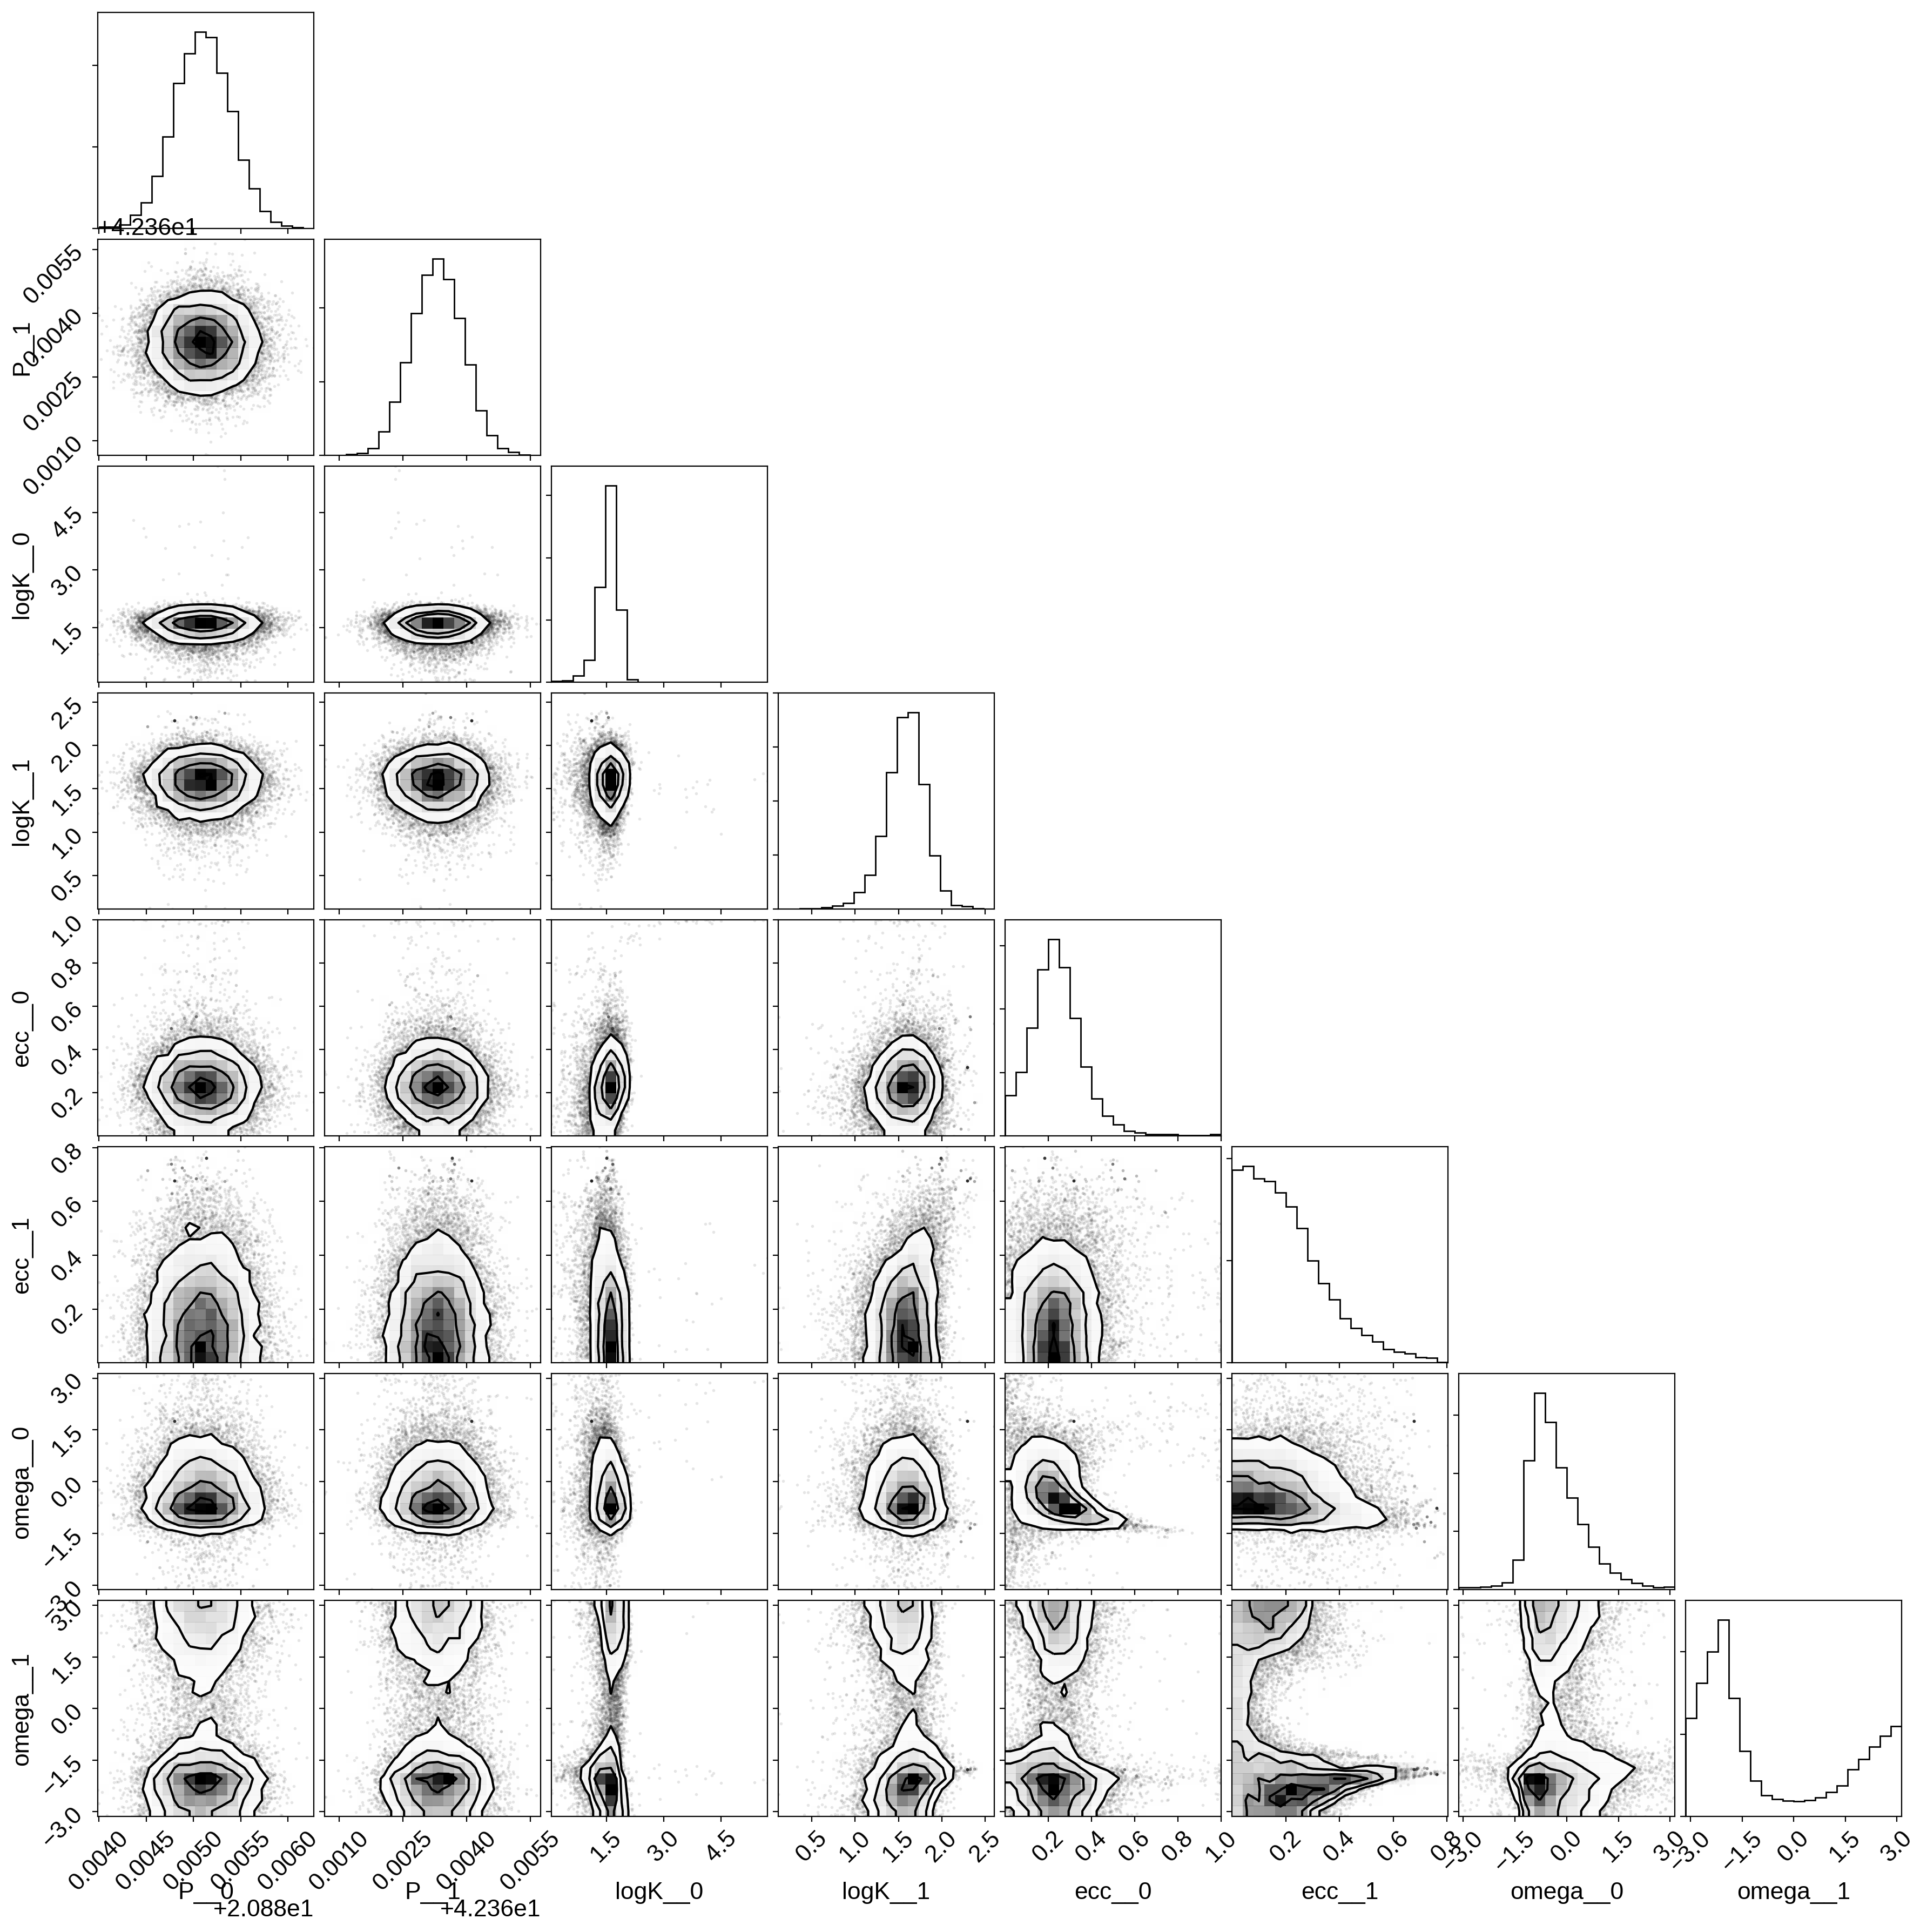

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

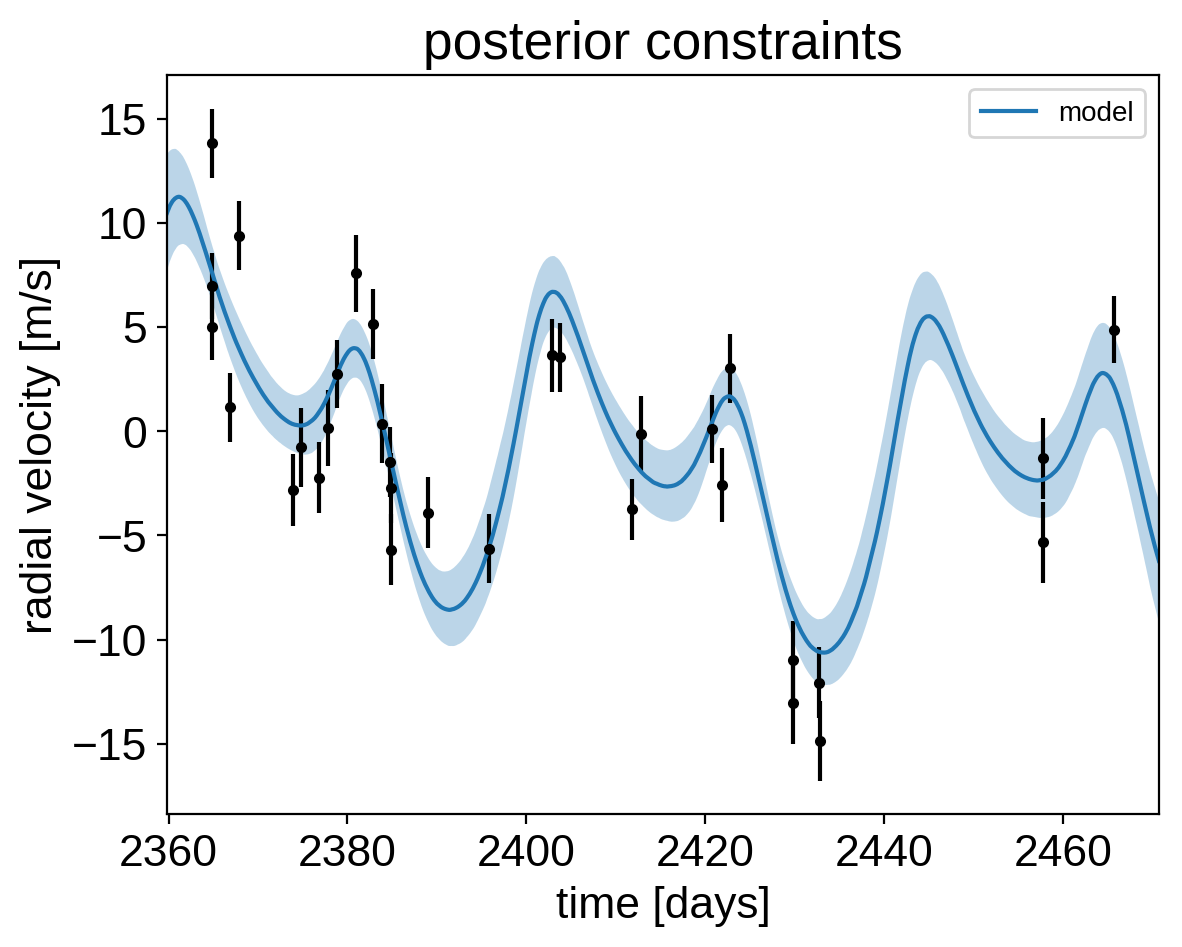

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

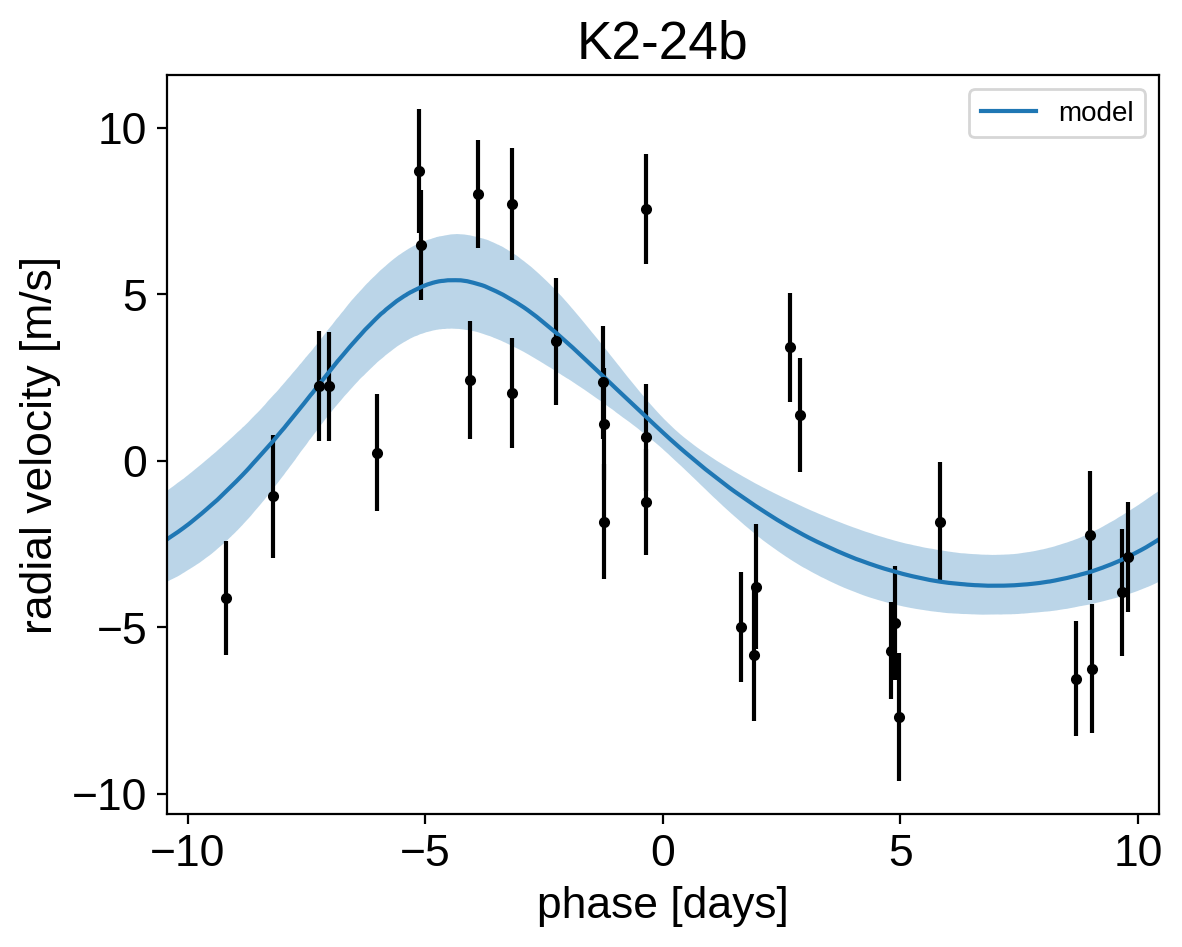

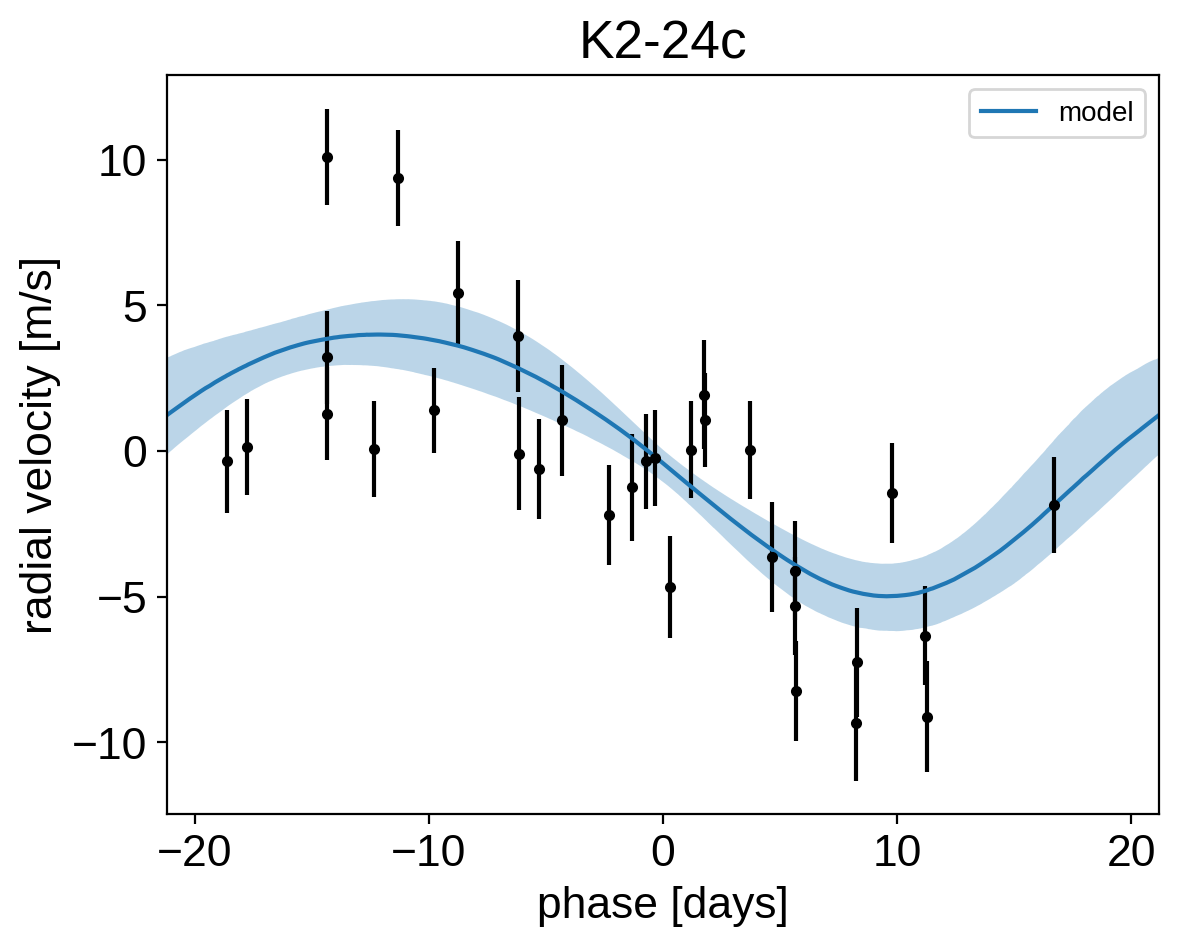

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
